In [1]:
#引包

import pandas as pd 
import numpy as np
from scipy.signal import medfilt
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torch
from torch.nn import init
import torch.nn.functional as F
import time

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

In [2]:
#初始参数
window_size = 1250
no_of_task = np.array(['原信号', '噪音', '取负', '时间反向', '打乱片段'] )
no_of_emo = np.array(['平静', '积极', '惊恐', '恶心'] )

transform_task = [0, 1, 2, 3, 4]
single_batch_size = len(transform_task)


noise_param = 15 #noise_amount
scale_param = 1.1 #scaling_factor
permu_param = 20 #permutation_pieces

## hyper parameters
total_fold = 10
dropout_rate = 0.5
batchsize = 128
actual_batch_size =  batchsize * single_batch_size
lr_decay_step = 50
lr_decay_rate = 0.6
epoch = 250
t_epoch = 70
initial_learning_rate = 0.0001
loss_coeff = [0.229, 0.227, 0.227, 0.045, 0.045, 0.227]

In [3]:
#网络结构 original
class model_CNN(nn.Module):
    def __init__(self):
        super(model_CNN,self).__init__()
        self.conv_unit = nn.Sequential(
            nn.BatchNorm1d(1),
            
            nn.Conv1d(in_channels=1,out_channels=32,kernel_size=33,stride=1,padding=16),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            
            nn.Conv1d(in_channels=32,out_channels=32,kernel_size=33,stride=1,padding=16),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),#1250*32
            
            nn.MaxPool1d(8,stride=2),#（1250-8+2*0）/2 + 1 = 622
            
            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=17,stride=1,padding=8),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=17,stride=1,padding=8),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),#622*64
            
            nn.MaxPool1d(8,stride=2),#（622-8+2*0）/2 + 1 = 308
            
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=9,stride=1,padding=4),
            nn.LeakyReLU(),
            
            nn.MaxPool1d(308),#308*128
            
            nn.Flatten(),#1*128
            nn.Dropout(0.2),#没有dropout，准确率会先上升后下降，最后涨到1？过拟合
        )
        
    def forward(self,inputs):#由于数据量小，10s为一个输入单位，后续增大数据量可以改为batch训练
        inputs = inputs.view(inputs.size()[0],1,inputs.size()[1])
        #inputs = inputs.view(1,1,inputs.size()[0])#only a batch
        inputs = self.conv_unit(inputs)
        inputs = inputs.view(inputs.size()[0],-1)
        #inputs = self.dense_unit(inputs)

        return inputs

class model_Task(nn.Module):
    def __init__(self):
        super(model_Task,self).__init__()

        self.task0 = nn.Sequential(
            nn.Linear(128,128),#1*128
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128,5),
            #nn.Softmax(dim=1)
        )
        
        
    def forward(self,inputs):

        out0 = self.task0(inputs)

        return out0
    
    
class model_Final(nn.Module):
    def __init__(self):
        super(model_Final,self).__init__()

        self.task = nn.Sequential(
            nn.Linear(128,512),#1*128
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,4),
            #nn.Softmax(dim=1)#pytorch crossentropyloss 不需要
        )
        
        
    def forward(self,inputs):#由于数据量小，10s为一个输入单位，后续增大数据量可以改为batch训练

        inputs = self.task(inputs)

        return inputs
    
#define the initial function to init the layer's parameters for the network
def weigth_init(m):
    if isinstance(m, nn.Conv1d):
        init.xavier_uniform_(m.weight.data)
        init.constant_(m.bias.data,0.1)
    elif isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0,0.01)
        m.bias.data.zero_()


In [5]:
#网络结构 
class model_CNN(nn.Module):
    def __init__(self):
        super(model_CNN,self).__init__()
        self.conv_unit = nn.Sequential(
            nn.BatchNorm1d(1),
            
            nn.Conv1d(in_channels=1,out_channels=32,kernel_size=33,stride=1,padding=16),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            
            nn.MaxPool1d(8,stride=2),#（1250-8+2*0）/2 + 1 = 622
            
            nn.Conv1d(in_channels=32,out_channels=64,kernel_size=17,stride=1,padding=8),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),#622*64
            nn.Dropout(0.2),
            
            nn.MaxPool1d(8,stride=2),#（622-8+2*0）/2 + 1 = 308
            
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=9,stride=1,padding=4),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.MaxPool1d(308),#308*128
            
            nn.Flatten(),#1*128
            nn.Dropout(0.2),#没有dropout，准确率会先上升后下降，最后涨到1？过拟合
        )
        
    def forward(self,inputs):#由于数据量小，10s为一个输入单位，后续增大数据量可以改为batch训练
        inputs = inputs.view(inputs.size()[0],1,inputs.size()[1])
        #inputs = inputs.view(1,1,inputs.size()[0])#only a batch
        inputs = self.conv_unit(inputs)
        inputs = inputs.view(inputs.size()[0],-1)
        #inputs = self.dense_unit(inputs)

        return inputs

class model_Task(nn.Module):
    def __init__(self):
        super(model_Task,self).__init__()

        self.task0 = nn.Sequential(
            nn.Linear(128,128),#1*128
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128,5),
            #nn.Softmax(dim=1)
        )
        
        
    def forward(self,inputs):

        out0 = self.task0(inputs)

        return out0
    
    
class model_Final(nn.Module):
    def __init__(self):
        super(model_Final,self).__init__()

        self.task = nn.Sequential(
            nn.Linear(128,128),#1*128
            nn.LeakyReLU(),
            nn.Dropout(0.8),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Dropout(0.8),
            nn.Linear(128,4),
            #nn.Softmax(dim=1)#pytorch crossentropyloss 不需要
        )
        
        
    def forward(self,inputs):#由于数据量小，10s为一个输入单位，后续增大数据量可以改为batch训练

        inputs = self.task(inputs)

        return inputs
    
#define the initial function to init the layer's parameters for the network
def weigth_init(m):
    if isinstance(m, nn.Conv1d):
        init.xavier_uniform_(m.weight.data)
        init.constant_(m.bias.data,0.1)
    elif isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0,0.01)
        m.bias.data.zero_()


In [6]:
# 解决中文显示问题 绘制
# import os
# import pandas as pd
# import numpy as np
# import torch
# from matplotlib import pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 定义画图函数
def plot_loss(epochs, train_loss, val_loss, text):
    x = np.arange(1,epochs+1)
    
    plt.plot(x,train_loss, label='train_loss')
    plt.plot(x,val_loss, label='val_loss')
    plt.legend(loc='best')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(text+"loss 图")
    plt.savefig('/home/whh/lt/pic/loss.png')
    plt.show()


def plot_acc(epochs, train_acc, val_acc, text):
    x = np.arange(1,epochs+1)
    
    plt.plot(x,train_acc, label='train_acc')
    plt.plot(x,val_acc, label='val_acc')
    plt.legend(loc='best')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.title(text+"acc 图")
    plt.savefig('/home/whh/lt/pic/acc.png')
    plt.show()


def plot_results(epochs, train_acc, train_loss, val_acc, val_loss, text):
    x = np.arange(1,epochs+1)

    plt.plot(x, train_acc, label='train_accuracy')
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, val_acc, label='val_accuracy')
    plt.plot(x, val_loss, label='val_loss')

    plt.title(text+"loss&acc ", fontsize=15)
    plt.xlabel("X", fontsize=13)
    plt.ylabel("Y", fontsize=13)
    plt.legend()
    plt.savefig('/home/whh/lt/pic/result.png')
    plt.show()

def plot_all(epochs, train_acc, train_loss, val_acc, val_loss, text):
    
    plot_acc(epochs, train_acc, val_acc, text)
    plot_loss(epochs, train_loss, val_loss, text)
    plot_results(epochs, train_acc, train_loss, val_acc, val_loss, text)
    
def get_confusion_matrix(trues, preds):
  conf_matrix = confusion_matrix(y_true = no_of_task[trues],y_pred = no_of_task[preds], labels = no_of_task )
  return conf_matrix
  
def plot_confusion_matrix(conf_matrix):
  plt.imshow(conf_matrix, cmap=plt.cm.Greens)
  indices = range(conf_matrix.shape[0])
  plt.xticks(indices, no_of_task )
  plt.yticks(indices, no_of_task )
  plt.colorbar()
  plt.xlabel('预测')
  plt.ylabel('真实')
  # 显示数据
  for first_index in range(conf_matrix.shape[1]):
    for second_index in range(conf_matrix.shape[0]):
      plt.text(first_index, second_index, conf_matrix[second_index, first_index])
  plt.savefig('/home/whh/lt/pic/pretask_heatmap_confusion_matrix.jpg')
  plt.show()

    
def get_confusion_matrix2(trues, preds, no_of_emo):
  conf_matrix = confusion_matrix(y_true = no_of_emo[trues],y_pred = no_of_emo[preds], labels = no_of_emo )
  return conf_matrix
  
def plot_confusion_matrix2(conf_matrix, no_of_emo):
  plt.imshow(conf_matrix, cmap=plt.cm.Greens)
  indices = range(conf_matrix.shape[0])
  plt.xticks(indices, no_of_emo )
  plt.yticks(indices, no_of_emo )
  plt.colorbar()
  plt.xlabel('预测')
  plt.ylabel('真实')
  # 显示数据
  for first_index in range(conf_matrix.shape[1]):
    for second_index in range(conf_matrix.shape[0]):
      plt.text(first_index, second_index, conf_matrix[second_index, first_index])
  plt.savefig('/home/whh/lt/pic/downstream_heatmap_confusion_matrix.jpg')
  plt.show()
    

In [7]:
#数据处理
def medfilt_ecg(original_ecg, window_size):
    # 确保窗大小变为奇数 
    window_size = window_size+1 if window_size % 2 == 0 else window_size
    give_up_size = int(window_size / 2)
    ecg_baseline = medfilt(original_ecg, window_size)
    totality_bias = np.sum(ecg_baseline[give_up_size:-give_up_size])/(len(original_ecg)-2*give_up_size)
    filtered_ecg = original_ecg - ecg_baseline
    final_filtered_ecg = filtered_ecg[give_up_size:-give_up_size]-totality_bias
    return final_filtered_ecg

def minus_ecg(original_ecg):
    ecg = (-1) * original_ecg
    return ecg

def shuffle_ecg(original_ecg,pieces):
    signal = original_ecg
    ecg =[]
    
    pieces       = int(np.ceil(np.shape(signal)[0]/(np.shape(signal)[0]//pieces)).tolist())
    piece_length = int(np.shape(signal)[0]//pieces)
    
    sequence = list(range(0,pieces))
    np.random.shuffle(sequence)
    
    permuted_signal = np.reshape(signal[:(np.shape(signal)[0]//pieces*pieces)], (pieces, piece_length)).tolist() + [signal[(np.shape(signal)[0]//pieces*pieces):]]
    
    for i in range(pieces):
        ecg += permuted_signal[sequence[i]]
    ecg.extend(permuted_signal[21])
    ecg = np.array(ecg,dtype = np.float32)
#     permuted_signal = np.asarray(permuted_signal,dtype=np.float32)[sequence]
#     ecg = np.hstack(permuted_signal))
    
    return ecg

def flip_ecg(original_ecg):
    
    ecg = np.flip(original_ecg)
    return ecg

def add_noise_with_SNR(original_ecg, noise_amount):
    signal = original_ecg
    
    target_snr_db = noise_amount #20
    x_watts = signal ** 2                       # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)   # Calculate noise then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))     # Generate an sample of white noise
    noised_signal = signal + noise_volts        # noise added signal

    return noised_signal 

In [7]:
# 加载原始数据
class MyData(Data.Dataset):
    def __init__(self, feature, label):
        self.feature = feature # 特征
        self.label = label # 标签

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        return self.feature[idx], self.label[idx]
    
    

def make_10(signals,label,train_signals_final,train_labels_final):
    train_signals = signals
    mid_num = len(train_signals)//1250
    train_signals= np.array_split(train_signals[:int(mid_num*1250)],mid_num)
    
    train_signals_final = np.vstack((train_signals_final,train_signals))if len(train_signals_final)!=0 else train_signals
    train_labels = np.full(int(mid_num),label) 
    train_labels_final = np.append(train_labels_final,train_labels)if len(train_labels_final)!=0 else train_labels
    return train_signals_final,train_labels_final
    
# def load_data_lt():
#     window_size = 37
#     train_signals_final =[]
#     train_labels_final =[]
    
#     # 加载原始数据positive1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681196859_pro_2_1681196592744.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据positive2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197134_pro_2_1681196863225.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197431_pro_2_1681197191396.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据positive3
#     df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197718_pro_2_1681197431761.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197849_pro_2_1681197769541.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据negative
#     df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681199024_pro_2_1681197966900.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
    
#     fear = train_signals[:45000]
#     train_signals_final,train_labels_final = make_10(fear,2,train_signals_final,train_labels_final)
    
#     sick = train_signals[45000:]
#     train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)

#     return train_signals_final,train_labels_final

# def load_data_mb():
#     window_size = 37
#     train_signals_final =[]
#     train_labels_final =[]
#     #mobiao
#     # 加载原始数据positive1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681306855404.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307342620.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据positive2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307738678.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307968220.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据negative
#     df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681308107324.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     sick = train_signals
#     train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
#     return train_signals_final,train_labels_final

# def load_data_smr():
#     window_size = 37
#     train_signals_final =[]
#     train_labels_final =[]
    
#     #sunmingrui
#     # 加载原始数据positive1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297303103.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297646913.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据positive2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298381797.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298714707.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据negative
#     df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681299073795.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     sick = train_signals
#     train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
#     return train_signals_final,train_labels_final

# def load_data_tc():
#     window_size = 37
#     train_signals_final =[]
#     train_labels_final =[]
    
#     #tancheng
#     # 加载原始数据positive1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681361364631.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362030617.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据positive2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362348275.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362617464.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据negative
#     df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681363292190.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     sick = train_signals
#     train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
#     return train_signals_final,train_labels_final

# def load_data_whf():
#     window_size = 37
#     train_signals_final =[]
#     train_labels_final =[]
    
#     #wuhongfu
#     # 加载原始数据positive1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681289705242.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290117226.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据positive2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290298306.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290764665.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据negative
#     df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290914931.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     sick = train_signals
#     train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
#     return train_signals_final,train_labels_final

# def load_data_yn():
#     window_size = 37
#     train_signals_final =[]
#     train_labels_final =[]
    
#     #yangnan
#     # 加载原始数据positive1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681356983934.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357438489.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据positive2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357726357.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
#     # 加载原始数据neutral2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358093581.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
#     # 加载原始数据negative1
#     df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358278670.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     fear = train_signals
#     train_signals_final,train_labels_final = make_10(fear,2,train_signals_final,train_labels_final)
    
#     # 加载原始数据negative2
#     df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358569551.csv')
#     # 拆解heartbeat_signals
#     train_signals = np.array(df_train['ecg'],dtype=np.float32)
#     #信号过滤
#     train_signals = medfilt_ecg(train_signals,window_size)
#     sick = train_signals
#     train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
#     return train_signals_final,train_labels_final

In [8]:
# 加载原始数据
class MyData(Data.Dataset):
    def __init__(self, feature, label):
        self.feature = feature # 特征
        self.label = label # 标签

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        return self.feature[idx], self.label[idx]
    
    

def make_10(signals,valence,arousal,train_signals_final,train_labels_final):
    train_signals = signals
    mid_num = len(train_signals)//1250
    train_signals= np.array_split(train_signals[:int(mid_num*1250)],mid_num)
    
    train_signals_final = np.vstack((train_signals_final,train_signals))if len(train_signals_final)!=0 else train_signals
    train_labels = np.full(int(mid_num),valence) 
    train_labels_valence = np.append(train_labels_valence,train_labels)if len(train_labels_valence)!=0 else train_labels
    
    train_labels = np.full(int(mid_num),arousal) 
    train_labels_arousal = np.append(train_labels_arousal,train_labels)if len(train_labels_arousal)!=0 else train_labels
    
    return train_signals_final,train_labels_valence,train_labels_arousal

def load_data_lt():
    window_size = 37
    train_signals_final =[]
    train_labels_valence =[]
    train_labels_arousal =[]
    
    # 加载原始数据positive 4
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681196859_pro_2_1681196592744.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,4,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197134_pro_2_1681196863225.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,4,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197431_pro_2_1681197191396.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive3
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197718_pro_2_1681197431761.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,3,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197849_pro_2_1681197769541.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,2,train_signals_final,train_labels_final)
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681199024_pro_2_1681197966900.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    
    fear = train_signals[:45000]
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(fear,0,5,train_signals_final,train_labels_final)
    
    sick = train_signals[45000:]
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(sick,0,1,train_signals_final,train_labels_final)

    return train_signals_final,train_labels_final

def load_data_mb():
    window_size = 37
    train_signals_final =[]
    train_labels_valence =[]
    train_labels_arousal =[]
    
    #mobiao
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681306855404.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,3,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307342620.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307738678.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,5,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307968220.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,2,train_signals_final,train_labels_final)
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681308107324.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(sick,0,5,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

def load_data_smr():
    window_size = 37
    train_signals_final =[]
    train_labels_valence =[]
    train_labels_arousal =[]
    
    #sunmingrui
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297303103.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,3,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297646913.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298381797.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,3,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298714707.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,1,train_signals_final,train_labels_final)
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681299073795.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(sick,0,1,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

def load_data_tc():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    #tancheng
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681361364631.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,1,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362030617.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,0,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362348275.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,4,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362617464.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,1,train_signals_final,train_labels_final)
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681363292190.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(sick,0,0,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

def load_data_whf():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    #wuhongfu
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681289705242.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,2,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290117226.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,0,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290298306.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,4,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290764665.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,1,train_signals_final,train_labels_final)
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290914931.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(sick,0,1,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

def load_data_yn():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    #yangnan
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681356983934.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,3,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357438489.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,0,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357726357.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,4,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358093581.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(train_signals,1,1,train_signals_final,train_labels_final)
    
    # 加载原始数据negative1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358278670.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    fear = train_signals
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(fear,0,4,train_signals_final,train_labels_final)
    
    # 加载原始数据negative2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358569551.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_valence,train_labels_arousal = make_10(sick,0,1,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

In [8]:
# 加载原始数据
class MyData(Data.Dataset):
    def __init__(self, feature, label):
        self.feature = feature # 特征
        self.label = label # 标签

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        return self.feature[idx], self.label[idx]
    
    

def make_10(signals,label,train_signals_final,train_labels_final):
    train_signals = []
    
    mid_num = len(signals[0:(len(signals)-1250)])//125
    for i in range(mid_num):
        train_signals = np.vstack((train_signals,signals[i*125:i*125+1250]))if len(train_signals)!=0 else signals[i*125:i*125+1250]
    
#     mid_num = len(train_signals)//1250
#     train_signals= np.array_split(train_signals[:int(mid_num*1250)],mid_num)
    
    train_signals_final = np.vstack((train_signals_final,train_signals))if len(train_signals_final)!=0 else train_signals
    train_labels = np.full(int(mid_num),label) 
    train_labels_final = np.append(train_labels_final,train_labels)if len(train_labels_final)!=0 else train_labels
    return train_signals_final,train_labels_final

def load_data_positive():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681196859_pro_2_1681196592744.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197134_pro_2_1681196863225.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681306855404.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive3
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197718_pro_2_1681197431761.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307738678.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
        
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297303103.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298381797.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681361364631.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362348275.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681289705242.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681356983934.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357726357.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)
    
    # 加载原始数据positive2
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290298306.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,1,train_signals_final,train_labels_final)

    return train_signals_final,train_labels_final

def load_data_neutral():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197431_pro_2_1681197191396.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681197849_pro_2_1681197769541.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307342620.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681297646913.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681307968220.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681298714707.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362030617.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290117226.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681362617464.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290764665.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681357438489.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    # 加载原始数据neutral2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358093581.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    train_signals_final,train_labels_final = make_10(train_signals,0,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

def load_data_sick():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/mobiao/2_1681308107324.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)

    
    
    # 加载原始数据_only sick
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681199024_pro_2_1681197966900.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals[45000:]
    train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/tancheng/2_1681363292190.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
    # 加载原始数据negative2
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358569551.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/sunmingrui/2_1681299073795.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
    # 加载原始数据negative
    df_train = pd.read_csv('/home/whh/lt/lt_data/wuhongfu/2_1681290914931.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    sick = train_signals
    train_signals_final,train_labels_final = make_10(sick,3,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

def load_data_fear():
    window_size = 37
    train_signals_final =[]
    train_labels_final =[]
    
    # 加载原始数据fear
    df_train = pd.read_csv('/home/whh/lt/lt_data/lt/179_2_3_1681199024_pro_2_1681197966900.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    fear = train_signals[:45000]
    train_signals_final,train_labels_final = make_10(fear,2,train_signals_final,train_labels_final)
    
    
    # 加载原始数据negative1
    df_train = pd.read_csv('/home/whh/lt/lt_data/yangnan/2_1681358278670.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['ecg'],dtype=np.float32)
    #信号过滤
    train_signals = medfilt_ecg(train_signals,window_size)
    fear = train_signals
    train_signals_final,train_labels_final = make_10(fear,2,train_signals_final,train_labels_final)
    
    return train_signals_final,train_labels_final

In [9]:
#数据划分
def get_train_test_index(data, kf, bias):
    train_index = []
    test_index = []
    for train_i, test_i in kf.split(data):
        train_index.append(train_i + bias)
        test_index.append(test_i + bias)

    return train_index, test_index

def make_batch(signal_batch, noise_amount, scaling_factor, permutation_pieces):
    """
    genrator to do signal transformation and then make a batch of 7, which is a batch contains all transformed signal with original signal"""
    
    for i in range(len(signal_batch)):
        
        signal              = signal_batch[i]
        #signal              = np.trim_zeros(signal, 'b')
        sampling_freq       = len(signal)//10
        noised_signal       = add_noise_with_SNR(signal, noise_amount = noise_amount) #round(np.random.uniform(0.005,0.05),2)) # 0.005 - 0.05
        negated_signal      = minus_ecg(signal)
        flipped_signal      = flip_ecg(signal)
        permuted_signal     = shuffle_ecg(signal, pieces = permutation_pieces) # 2-20
        
        signal                  = signal.reshape(1,len(signal))
        noised_signal           = noised_signal.reshape(1,len(noised_signal))
        negated_signal          = negated_signal.reshape(1,len(negated_signal))
        flipped_signal          = flipped_signal.reshape(1,len(flipped_signal))
        permuted_signal         = permuted_signal.reshape(1,len(permuted_signal))

        batch = np.vstack((signal.astype(np.float32), noised_signal.astype(np.float32)))
        batch = np.vstack((batch, negated_signal.astype(np.float32)))
        batch = np.vstack((batch, flipped_signal.astype(np.float32)))
        batch = np.vstack((batch, permuted_signal.astype(np.float32)))#2560*7
        
        labels = transform_task#shuffle
        np.random.shuffle(labels)
        batch = batch[labels]
        
        labels = np.array(labels).reshape(len(transform_task),1)
        
#         data_tensor = torch.LongTensor(labels)
#         labels = F.one_hot(data_tensor) 
    
        yield np.array(batch,dtype=np.float32), labels#128*6*1250
        
def make_total_batch(data, length, batchsize, noise_amount, scaling_factor, permutation_pieces):
    """ calling make_batch from here, when batch size is more than one, like 64 or 32, it will make actual batch size = batch_size * len(transformed signal)
    """
    steps = length // batchsize +1
    for counter in range(steps):

        signal_batch = data[np.mod(np.arange(counter*batchsize,(counter+1)*batchsize), length)]
        
        gen_op =  make_batch(signal_batch, noise_amount, scaling_factor, permutation_pieces)
        total_batch = np.array([])
        total_labels = np.array([])
        for batch, labels in gen_op:

            total_batch = np.vstack((total_batch, batch)) if len(total_batch) else batch # 2560 * 7个， 且最后一个batch不够128的话从前面取值补上去
            total_labels = np.vstack((total_labels, labels)) if len(total_labels) else labels

        yield np.array(total_batch,dtype=np.float32), total_labels, counter, steps#total batch中有128个数据，一个数据有7*2560个，即原信号+处理的信号共7个
        


In [10]:
#数据加载
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=total_fold, shuffle=True, random_state=True)

# train_signals_final,train_labels_final = load_data_lt()
# train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
# load_data = np.hstack((train_labels_final,train_signals_final))

# train_signals_final,train_labels_final = load_data_tc()
# train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
# mid_data = np.hstack((train_labels_final,train_signals_final))
# load_data = np.vstack((load_data,mid_data))

# train_signals_final,train_labels_final = load_data_yn()
# train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
# mid_data = np.hstack((train_labels_final,train_signals_final))
# load_data = np.vstack((load_data,mid_data))

# train_signals_final,train_labels_final = load_data_mb()
# train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
# mid_data = np.hstack((train_labels_final,train_signals_final))
# load_data = np.vstack((load_data,mid_data))

# train_signals_final,train_labels_final = load_data_whf()
# train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
# mid_data = np.hstack((train_labels_final,train_signals_final))
# load_data = np.vstack((load_data,mid_data))

# train_signals_final,train_labels_final = load_data_smr()
# train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
# mid_data = np.hstack((train_labels_final,train_signals_final))
# load_data = np.vstack((load_data,mid_data))

train_signals_final,train_labels_final = load_data_neutral()
train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
neutral_data = np.hstack((train_labels_final,train_signals_final))
train_index_neutral, test_index_neutral = get_train_test_index(neutral_data, kf, 0)
# train_index, test_index = train_index_neutral, test_index_neutral
load_data = neutral_data

train_signals_final,train_labels_final = load_data_positive()
train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
positive_data = np.hstack((train_labels_final,train_signals_final))
train_index_positive, test_index_positive = get_train_test_index(positive_data, kf, load_data.shape[0])
# train_index = np.hstack((train_index , train_index_positive))
# test_index = np.hstack((test_index , test_index_positive))
load_data = np.vstack((load_data,positive_data))

train_signals_final,train_labels_final = load_data_sick()
train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
sick_data = np.hstack((train_labels_final,train_signals_final))
train_index_sick, test_index_sick = get_train_test_index(sick_data, kf, load_data.shape[0])
# train_index = np.hstack((train_index , train_index_sick))
# test_index = np.hstack((test_index , test_index_sick))
load_data = np.vstack((load_data,sick_data))

train_signals_final,train_labels_final = load_data_fear()
train_labels_final = np.reshape(train_labels_final,[np.shape(train_labels_final)[0],1])
fear_data = np.hstack((train_labels_final,train_signals_final))
train_index_fear, test_index_fear = get_train_test_index(fear_data, kf, load_data.shape[0])
# train_index = np.hstack((train_index , train_index_fear))
# test_index = np.hstack((test_index , test_index_fear))
load_data = np.vstack((load_data,fear_data))


In [11]:
print(load_data.shape)

(24230, 1251)


In [14]:
 tr_total_gen_op = make_total_batch(data = train_ECG, length = training_length, batchsize = batchsize, 
                                                   noise_amount=noise_param, 
                                                   scaling_factor=scale_param, 
                                                   permutation_pieces=permu_param)

for training_batch, training_labels, tr_counter, tr_steps in tr_total_gen_op: 
    print(tr_steps)
    
print(tr_counter)

=====开始训练网络=====
=====FOLD_0=====


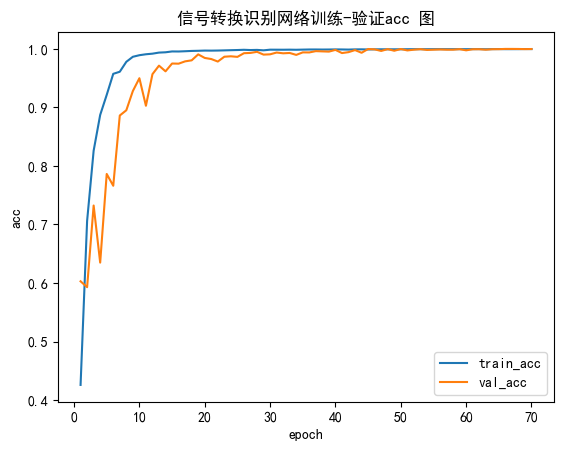

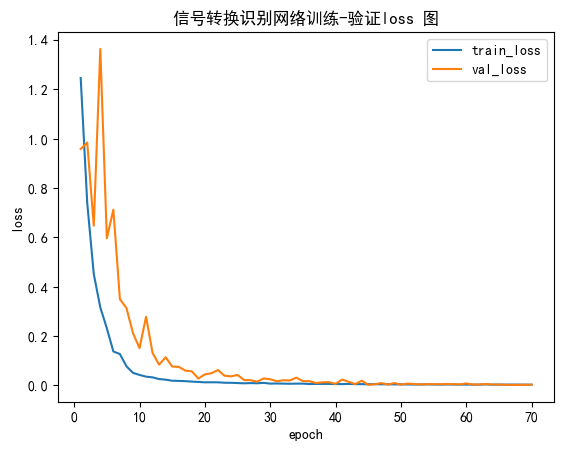

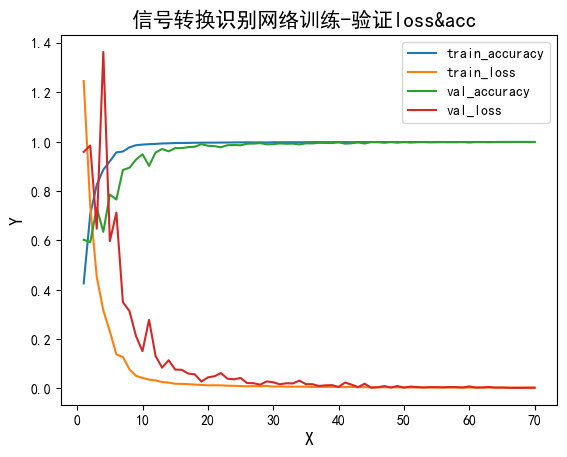

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       1.00      1.00      1.00      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2428    0    0    0    4]
 [   0 2432    0    0    0]
 [   0    0 2432    0    0]
 [   0    0    0 2432    0]
 [   3    0    0    0 2429]]


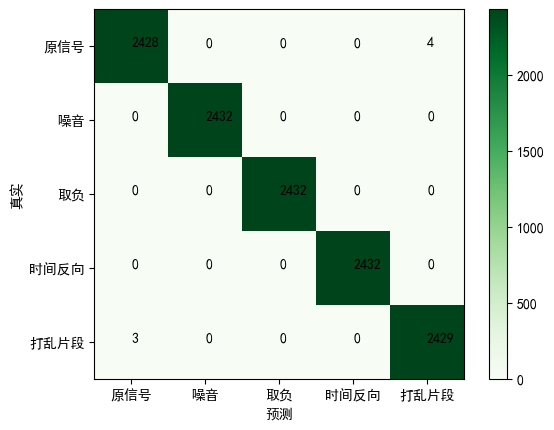

[信号转换识别网络测试] accuracy:0.9994 precision:0.9994 recall:0.9994 f1:0.9994
保存最优信号转换模型model 0


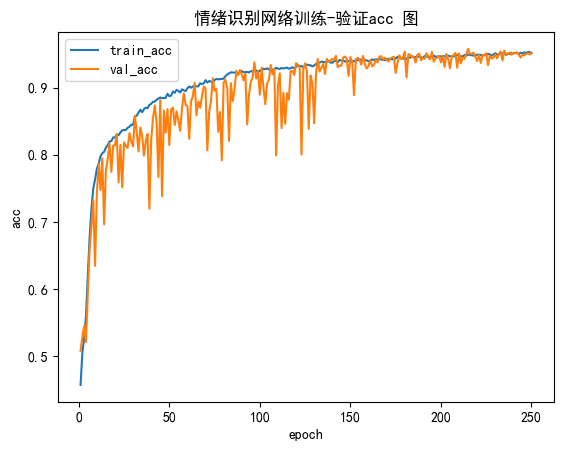

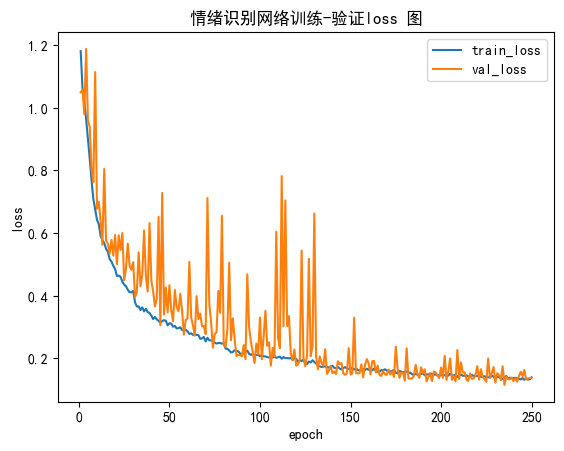

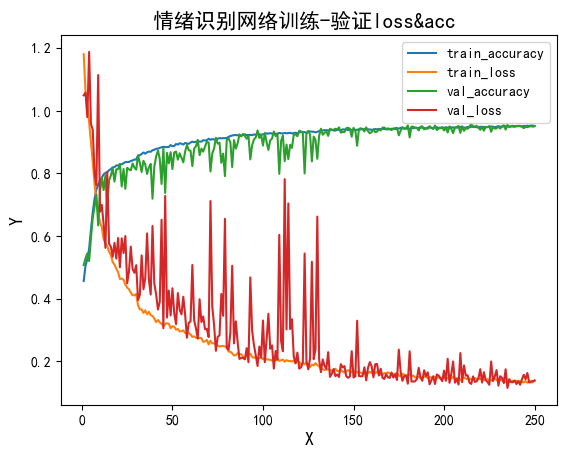

              precision    recall  f1-score   support

           0       0.69      0.95      0.80       223
           1       0.98      0.99      0.99       881
           2       0.00      0.00      0.00        91
           3       1.00      0.99      1.00      1230

    accuracy                           0.95      2425
   macro avg       0.67      0.73      0.70      2425
weighted avg       0.93      0.95      0.94      2425

[[ 212    9    0    2]
 [   5  874    0    2]
 [  86    5    0    0]
 [   4    1    3 1222]]


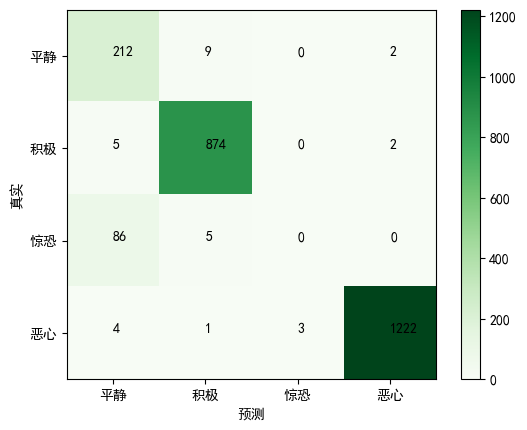

[情绪识别网络测试] accuracy:0.9518 precision:0.9518 recall:0.9518 f1:0.9518
保存最优情绪识别模型model 0
=====FOLD_1=====


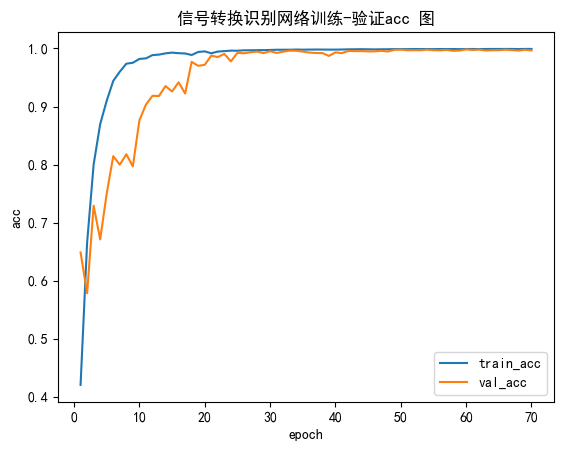

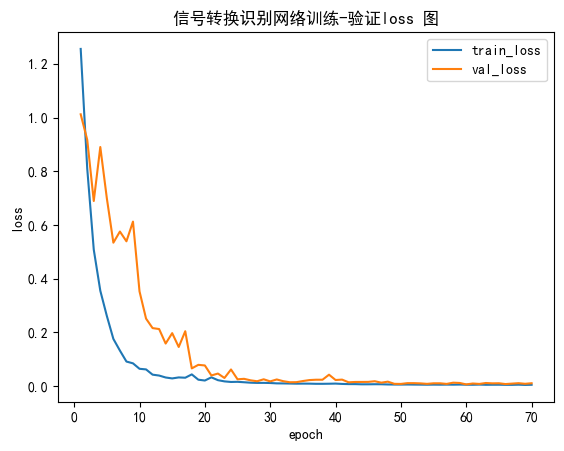

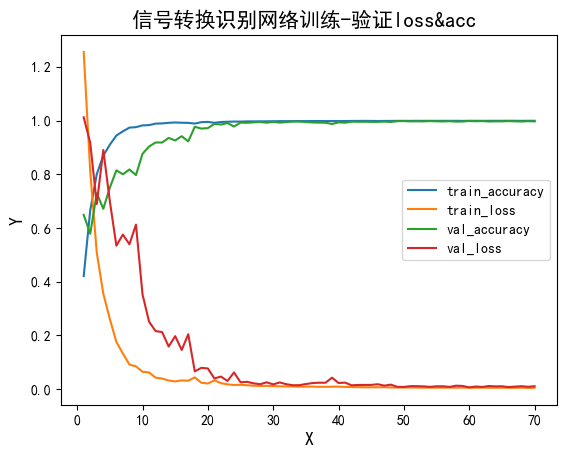

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       0.98      1.00      0.99      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2395    0    0    0   37]
 [   0 2431    0    0    1]
 [   0    0 2432    0    0]
 [   0    0    0 2432    0]
 [   2    0    0    0 2430]]


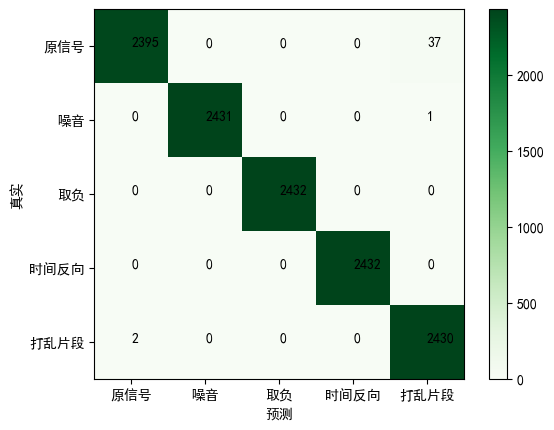

[信号转换识别网络测试] accuracy:0.9967 precision:0.9967 recall:0.9967 f1:0.9967


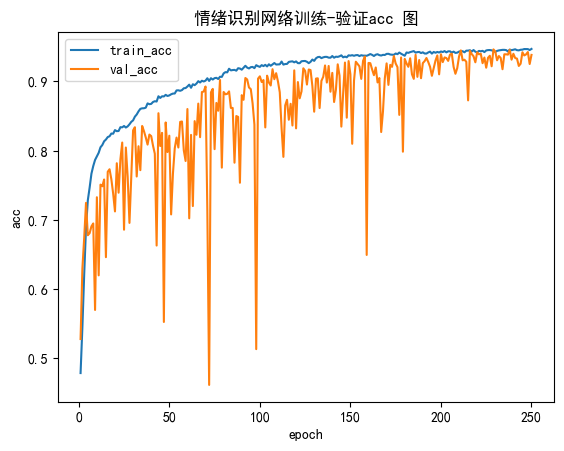

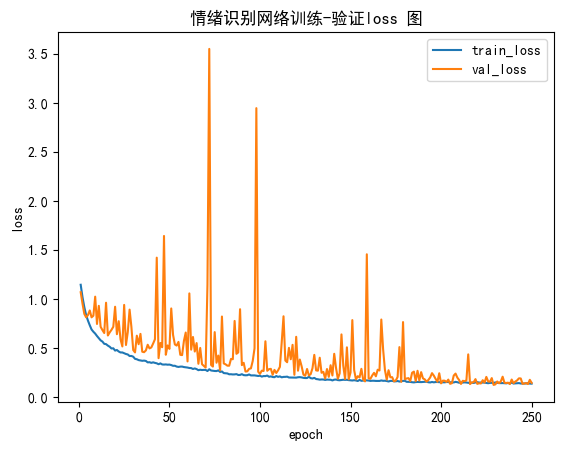

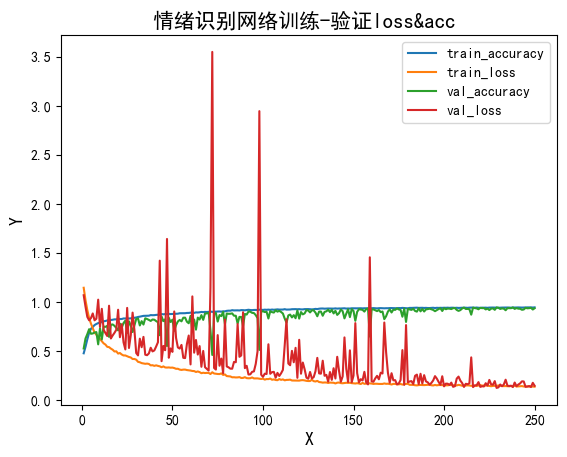

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.69      0.89      0.78       223
           1       0.96      0.99      0.97       881
           2       0.00      0.00      0.00        91
           3       0.98      0.98      0.98      1230

    accuracy                           0.94      2425
   macro avg       0.66      0.71      0.68      2425
weighted avg       0.91      0.94      0.92      2425

[[ 198   16    0    9]
 [  13  868    0    0]
 [  75    0    0   16]
 [   0   21    0 1209]]


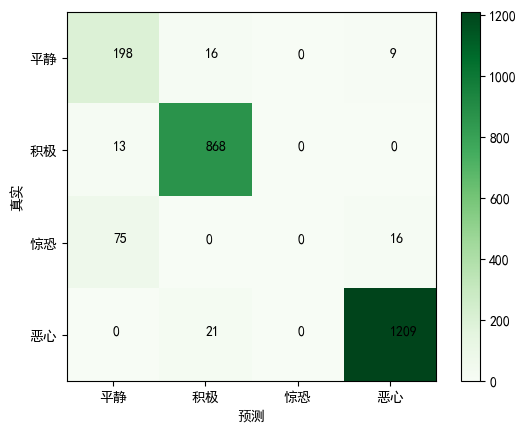

[情绪识别网络测试] accuracy:0.9381 precision:0.9381 recall:0.9381 f1:0.9381
=====FOLD_2=====


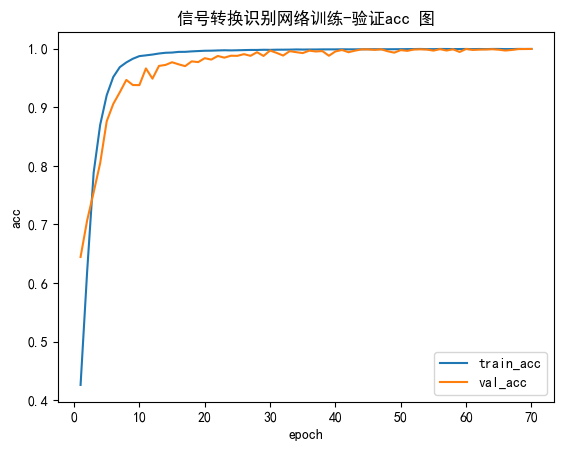

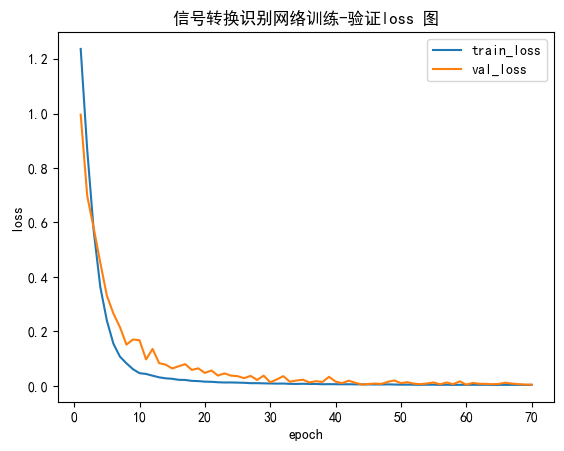

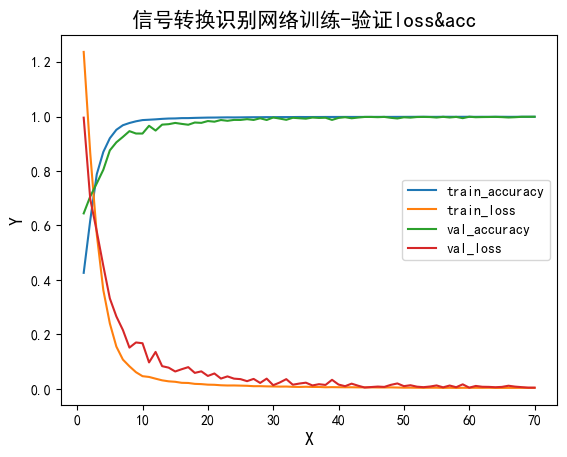

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       1.00      1.00      1.00      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2428    0    0    0    4]
 [   0 2431    0    0    1]
 [   0    0 2432    0    0]
 [   2    0    0 2430    0]
 [   0    0    0    0 2432]]


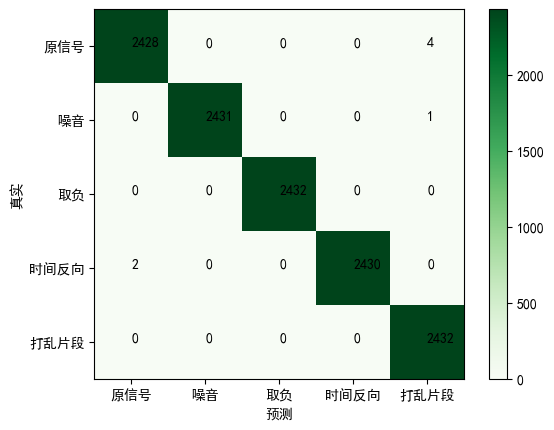

[信号转换识别网络测试] accuracy:0.9994 precision:0.9994 recall:0.9994 f1:0.9994


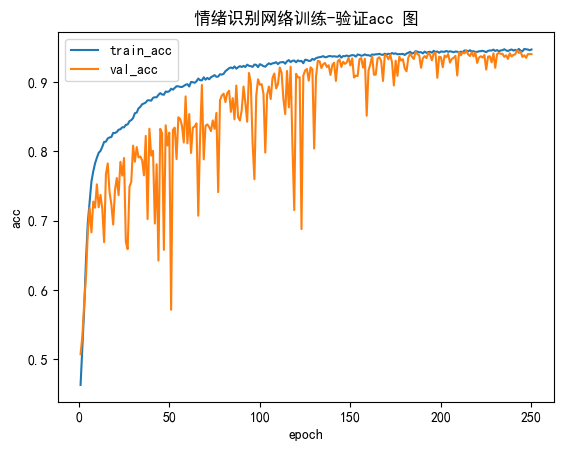

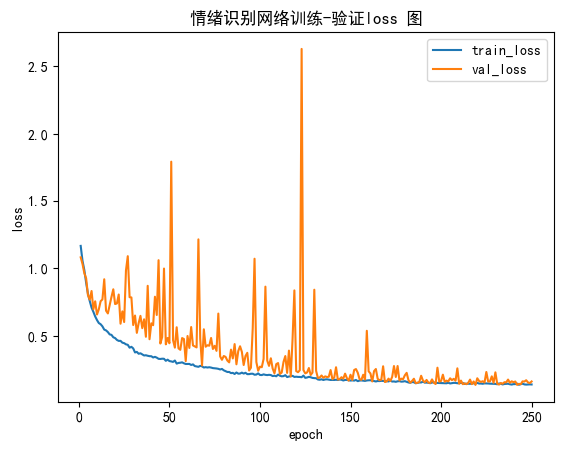

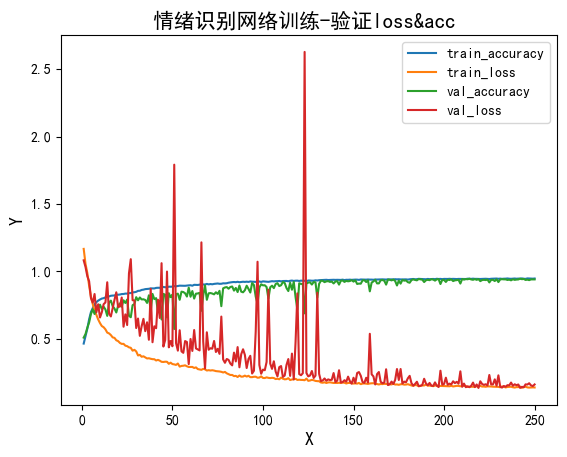

              precision    recall  f1-score   support

           0       0.66      0.95      0.78       223
           1       0.99      0.98      0.98       881
           2       1.00      0.01      0.02        91
           3       0.98      0.98      0.98      1230

    accuracy                           0.94      2425
   macro avg       0.91      0.73      0.69      2425
weighted avg       0.95      0.94      0.93      2425

[[ 212    3    0    8]
 [  16  865    0    0]
 [  71    0    1   19]
 [  20    9    0 1201]]


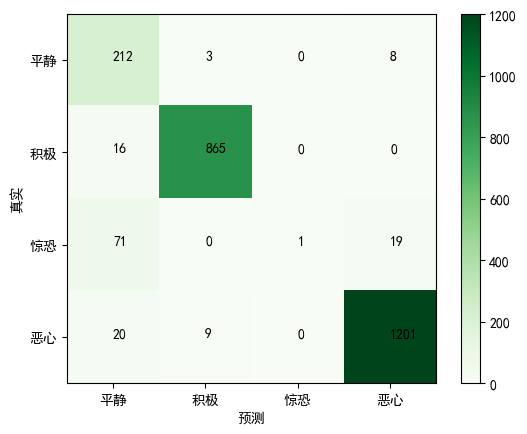

[情绪识别网络测试] accuracy:0.9398 precision:0.9398 recall:0.9398 f1:0.9398
=====FOLD_3=====


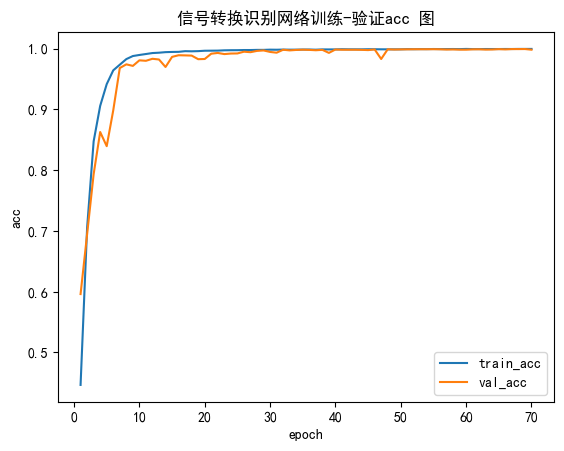

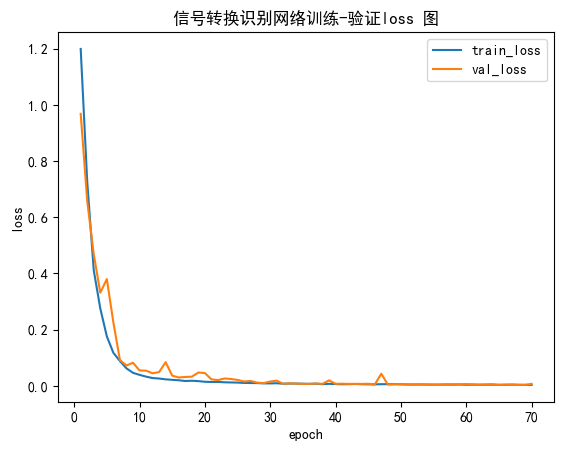

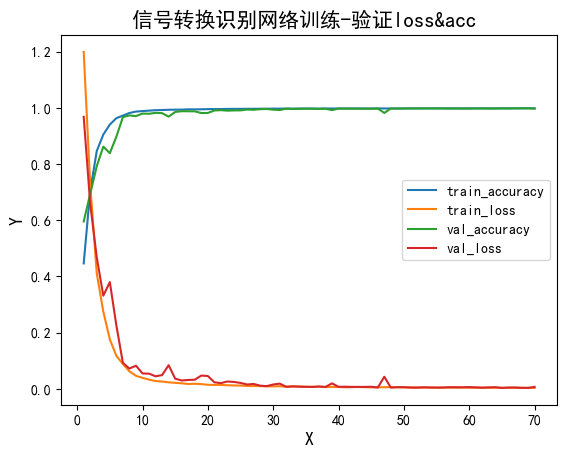

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       0.99      1.00      1.00      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2422    0    0    0   10]
 [   0 2423    0    0    9]
 [   0    0 2432    0    0]
 [   1    0    0 2431    0]
 [   3    0    0    0 2429]]


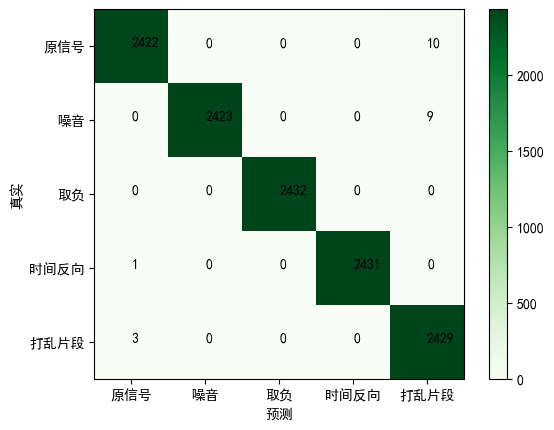

[信号转换识别网络测试] accuracy:0.9981 precision:0.9981 recall:0.9981 f1:0.9981


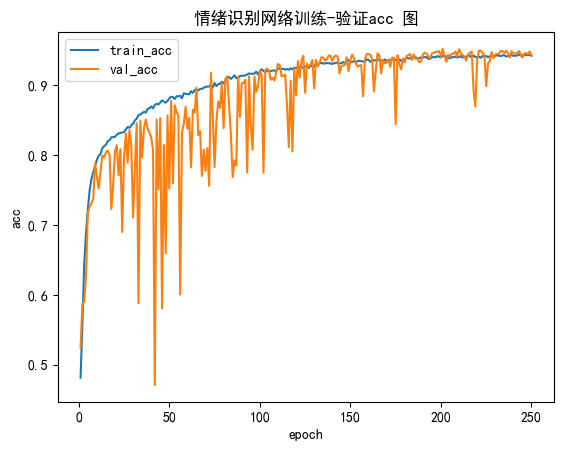

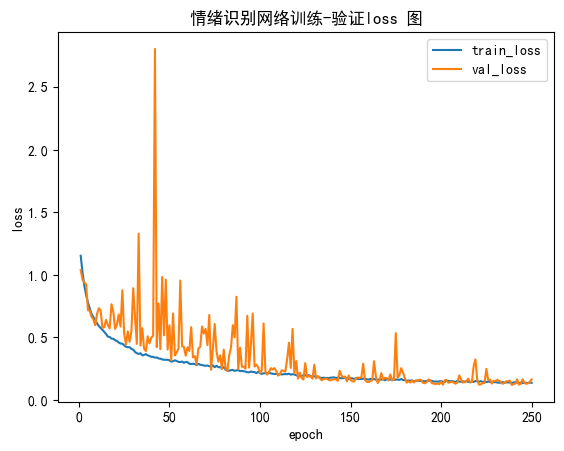

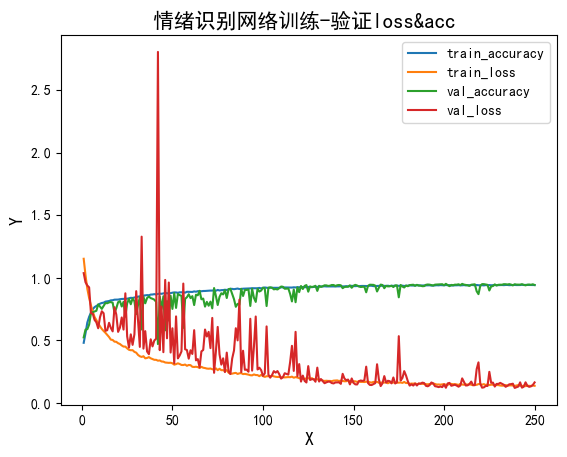

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.66      0.96      0.78       223
           1       1.00      0.97      0.98       881
           2       0.00      0.00      0.00        91
           3       0.98      0.99      0.99      1229

    accuracy                           0.94      2424
   macro avg       0.66      0.73      0.69      2424
weighted avg       0.92      0.94      0.93      2424

[[ 213    2    0    8]
 [  26  852    0    3]
 [  76    0    0   15]
 [   8    1    0 1220]]


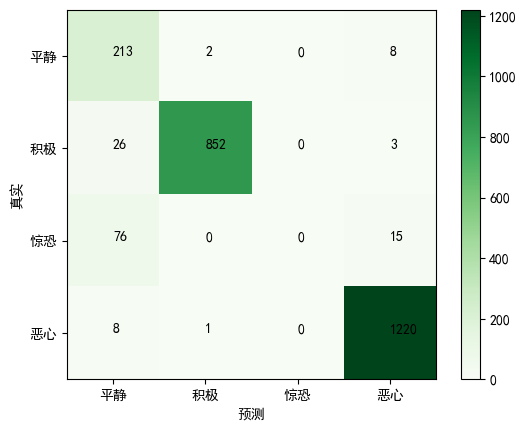

[情绪识别网络测试] accuracy:0.9427 precision:0.9427 recall:0.9427 f1:0.9427
=====FOLD_4=====


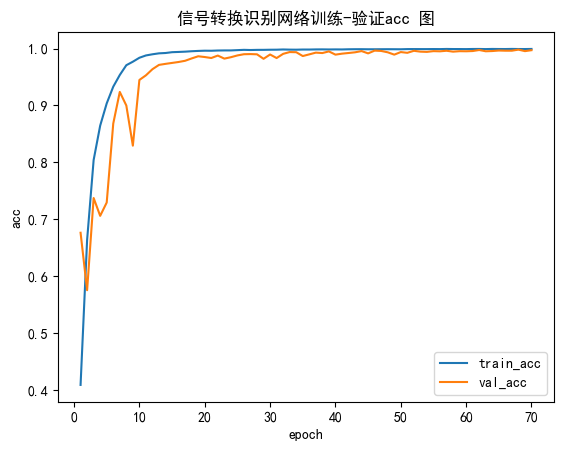

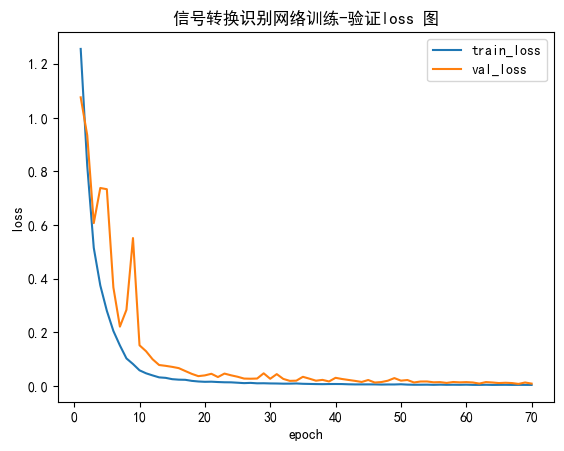

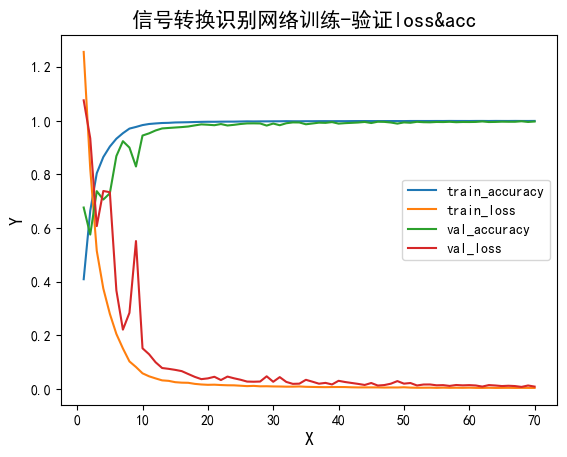

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       0.99      1.00      0.99      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2405    1    0    0   26]
 [   0 2431    0    0    1]
 [   0    0 2432    0    0]
 [   1    0    1 2429    1]
 [   1    3    0    0 2428]]


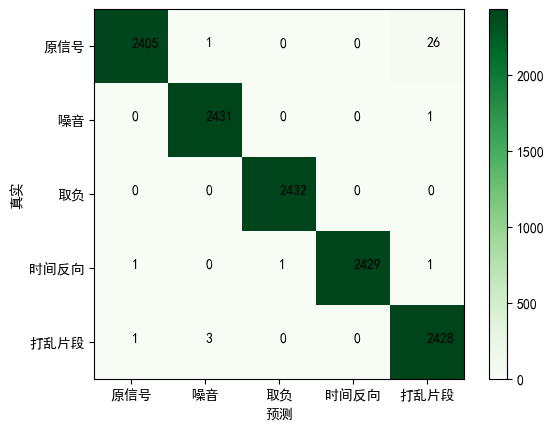

[信号转换识别网络测试] accuracy:0.9971 precision:0.9971 recall:0.9971 f1:0.9971


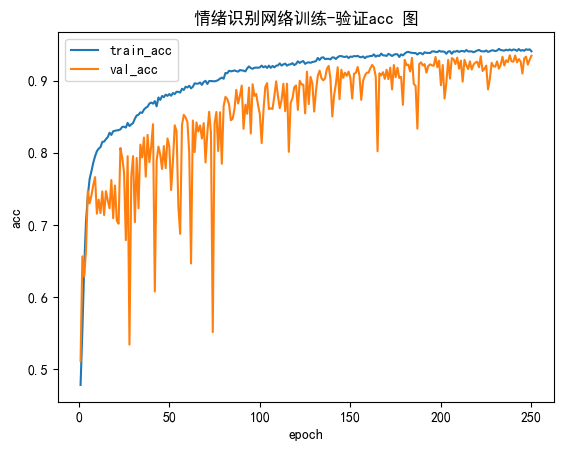

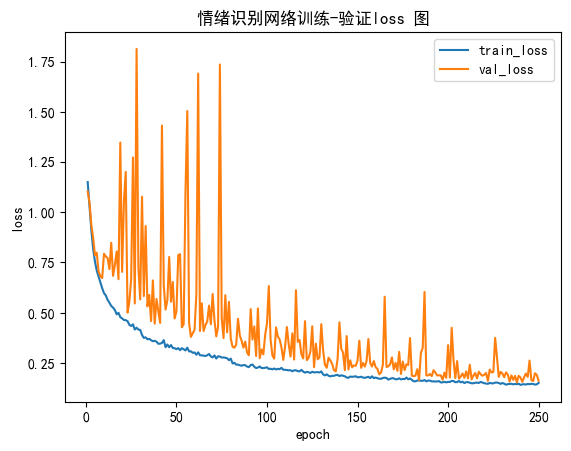

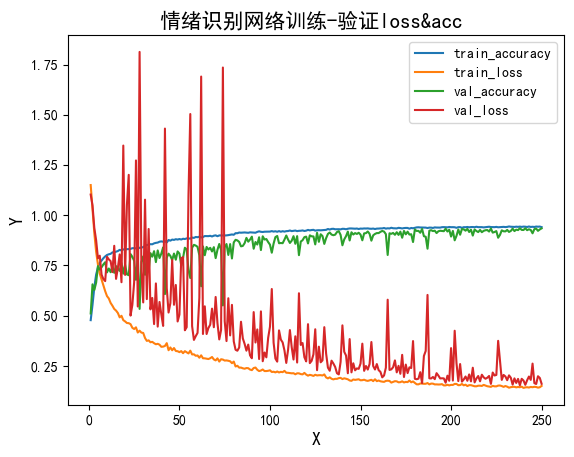

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.64      0.85      0.73       223
           1       0.99      0.96      0.98       881
           2       0.00      0.00      0.00        90
           3       0.96      1.00      0.98      1229

    accuracy                           0.93      2423
   macro avg       0.65      0.70      0.67      2423
weighted avg       0.91      0.93      0.92      2423

[[ 190    6    0   27]
 [  32  846    0    3]
 [  74    0    0   16]
 [   1    0    0 1228]]


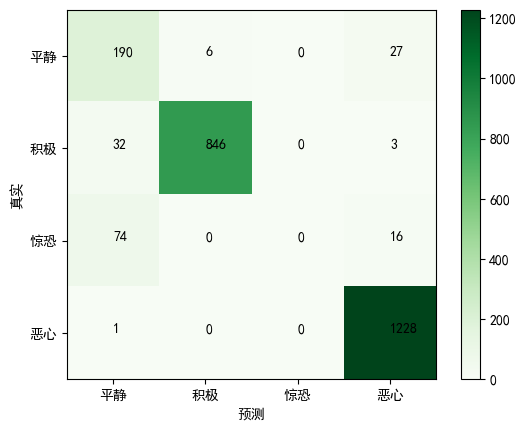

[情绪识别网络测试] accuracy:0.9344 precision:0.9344 recall:0.9344 f1:0.9344
=====FOLD_5=====


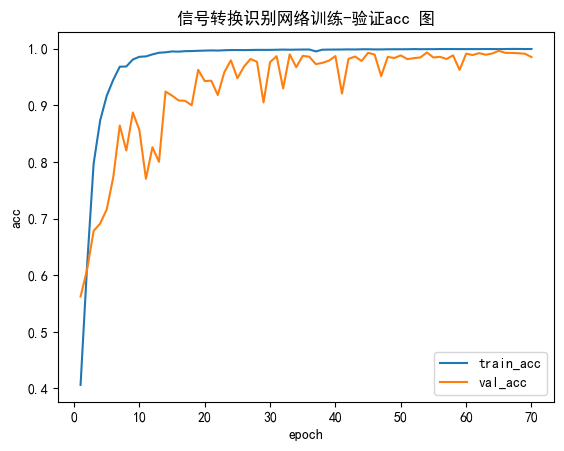

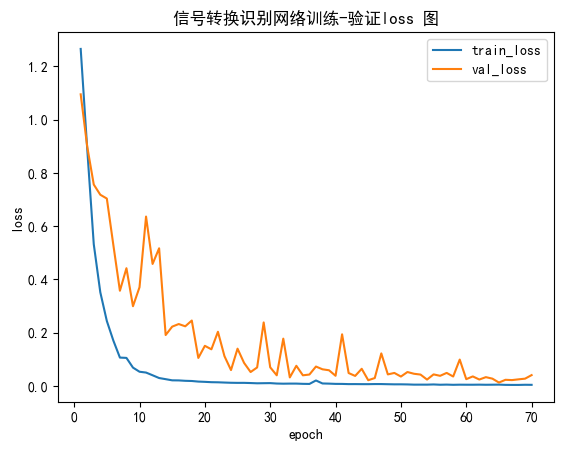

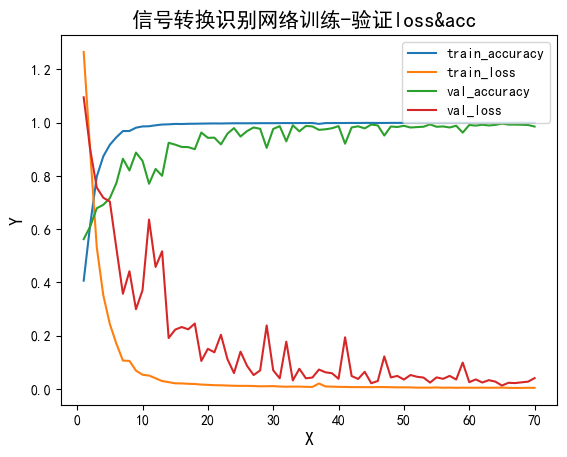

              precision    recall  f1-score   support

           0       1.00      0.93      0.97      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      0.99      1.00      2432
           4       0.93      1.00      0.97      2432

    accuracy                           0.99     12160
   macro avg       0.99      0.99      0.99     12160
weighted avg       0.99      0.99      0.99     12160

[[2273    1    0    0  158]
 [   0 2429    0    0    3]
 [   0    0 2432    0    0]
 [   4    0    1 2416   11]
 [   1    3    0    0 2428]]


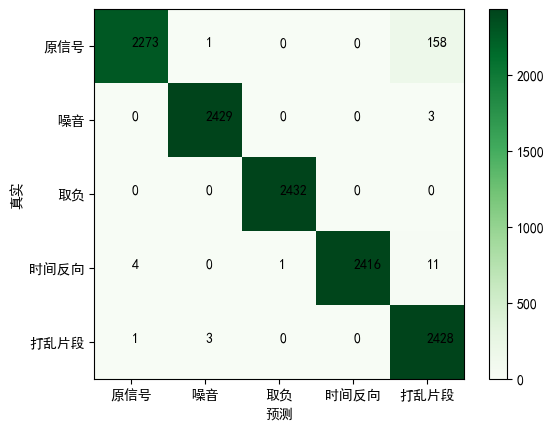

[信号转换识别网络测试] accuracy:0.9850 precision:0.9850 recall:0.9850 f1:0.9850


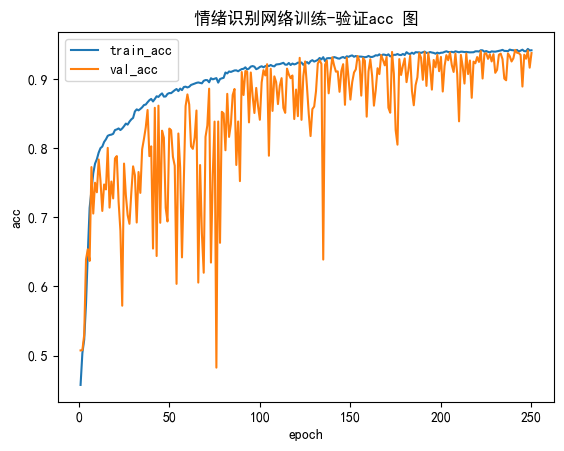

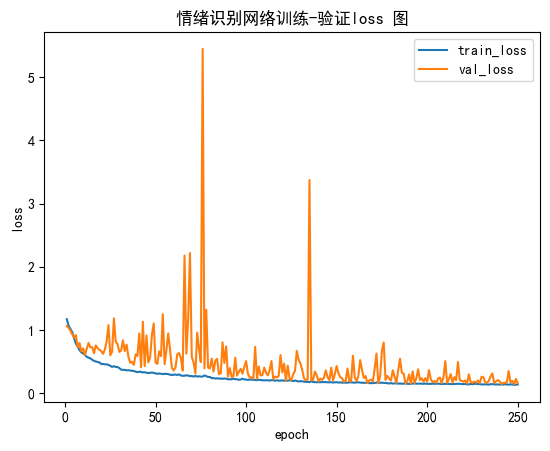

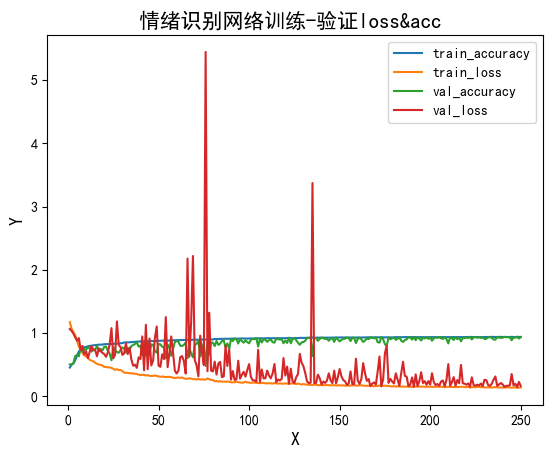

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.63      0.98      0.76       223
           1       0.97      0.97      0.97       880
           2       0.00      0.00      0.00        90
           3       1.00      0.97      0.99      1229

    accuracy                           0.94      2422
   macro avg       0.65      0.73      0.68      2422
weighted avg       0.92      0.94      0.92      2422

[[ 218    5    0    0]
 [  25  855    0    0]
 [  90    0    0    0]
 [  14   17    0 1198]]


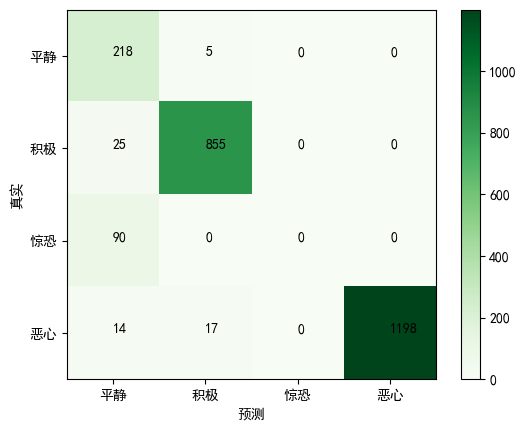

[情绪识别网络测试] accuracy:0.9377 precision:0.9377 recall:0.9377 f1:0.9377
=====FOLD_6=====


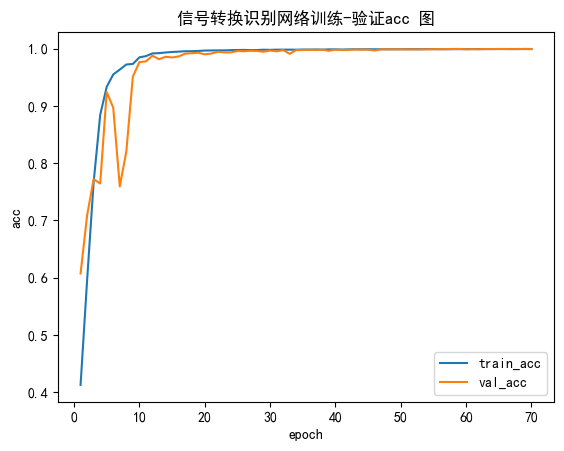

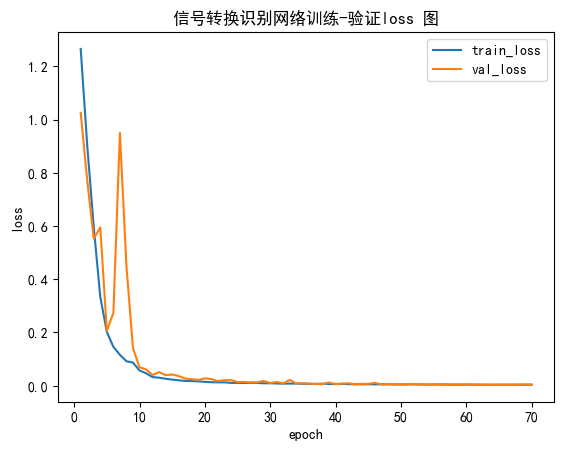

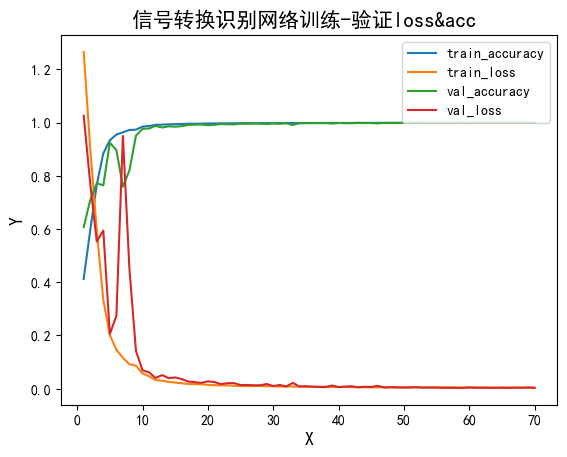

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       1.00      1.00      1.00      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2429    0    0    0    3]
 [   0 2428    0    0    4]
 [   0    0 2432    0    0]
 [   0    0    0 2432    0]
 [   2    0    0    0 2430]]


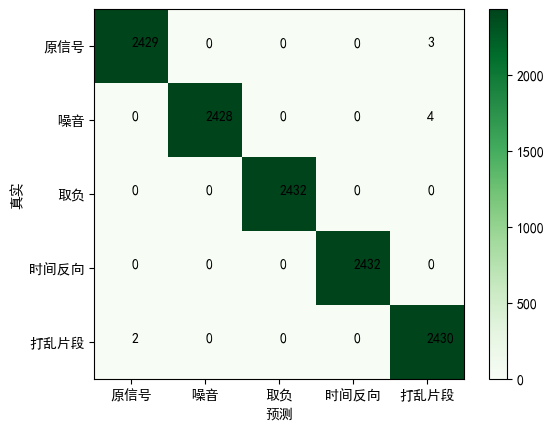

[信号转换识别网络测试] accuracy:0.9993 precision:0.9993 recall:0.9993 f1:0.9993


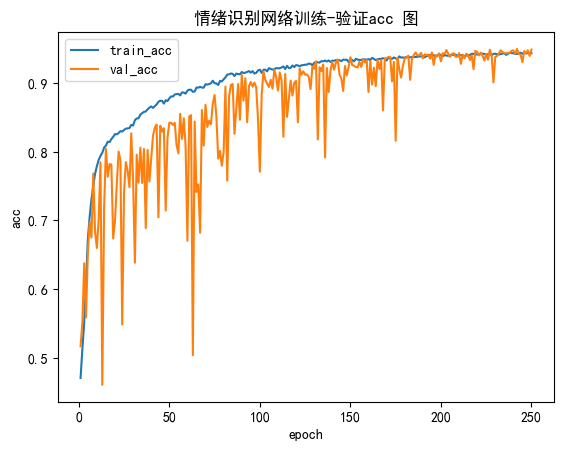

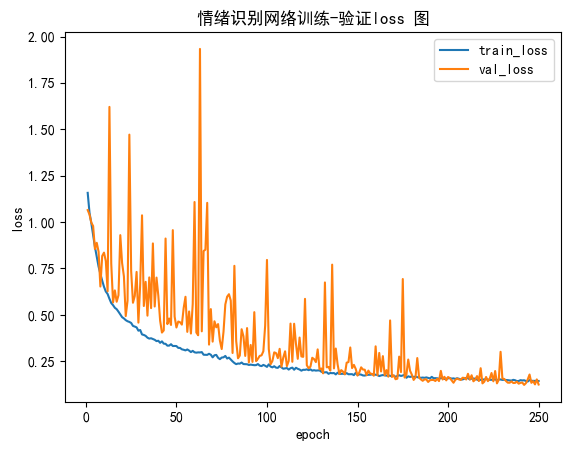

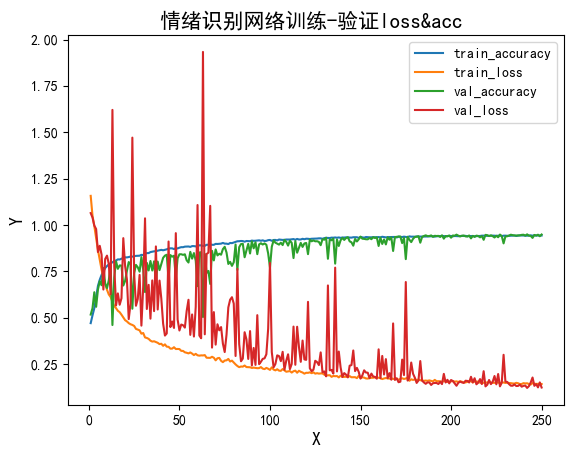

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.68      0.94      0.79       223
           1       0.99      0.98      0.99       880
           2       0.00      0.00      0.00        90
           3       0.98      1.00      0.99      1229

    accuracy                           0.95      2422
   macro avg       0.66      0.73      0.69      2422
weighted avg       0.92      0.95      0.93      2422

[[ 209    6    0    8]
 [  14  866    0    0]
 [  78    0    0   12]
 [   5    1    0 1223]]


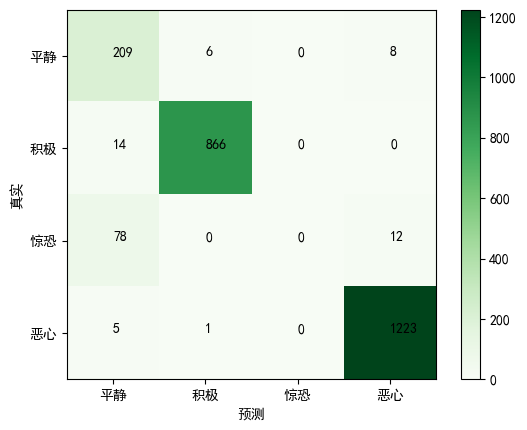

[情绪识别网络测试] accuracy:0.9488 precision:0.9488 recall:0.9488 f1:0.9488
=====FOLD_7=====


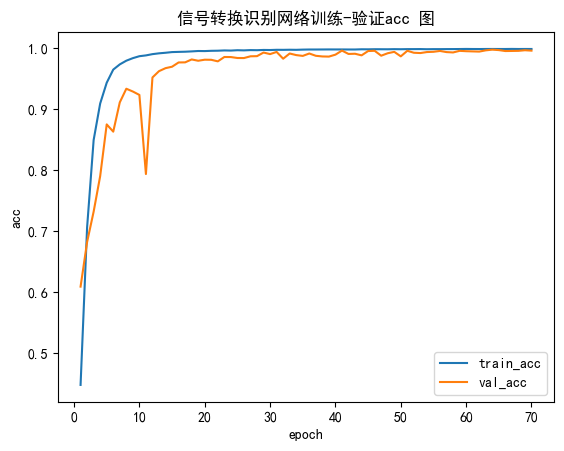

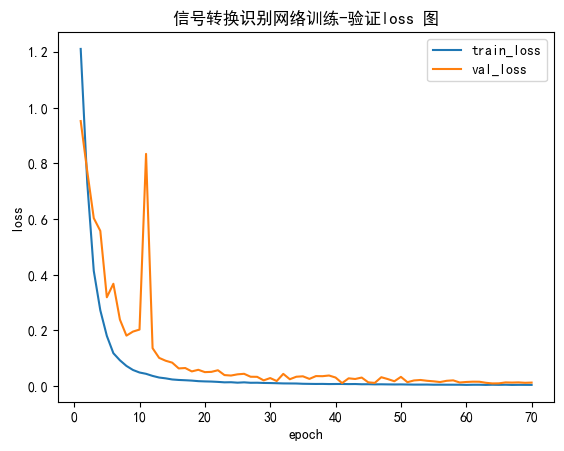

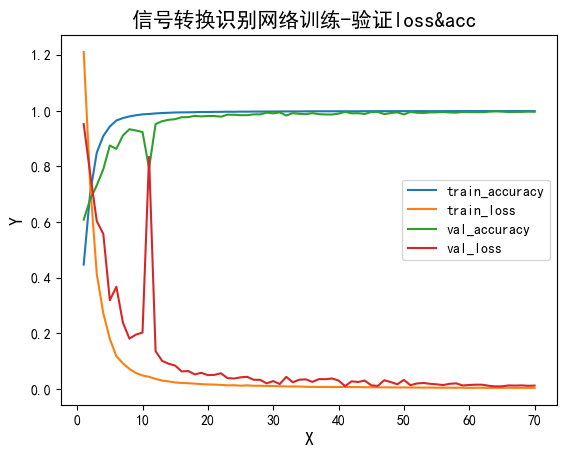

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       0.99      1.00      0.99      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2402    0    0    0   30]
 [   0 2429    0    0    3]
 [   0    0 2432    0    0]
 [   3    2    0 2423    4]
 [   1    0    0    0 2431]]


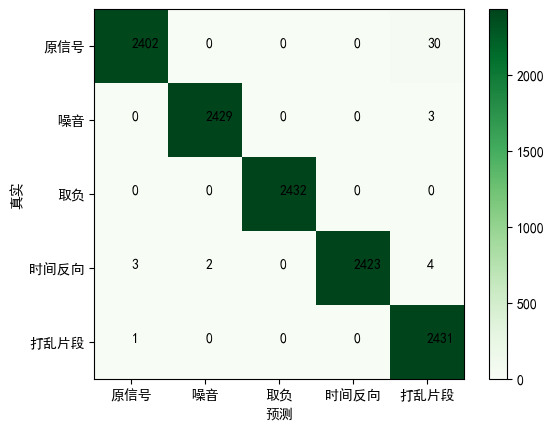

[信号转换识别网络测试] accuracy:0.9965 precision:0.9965 recall:0.9965 f1:0.9965


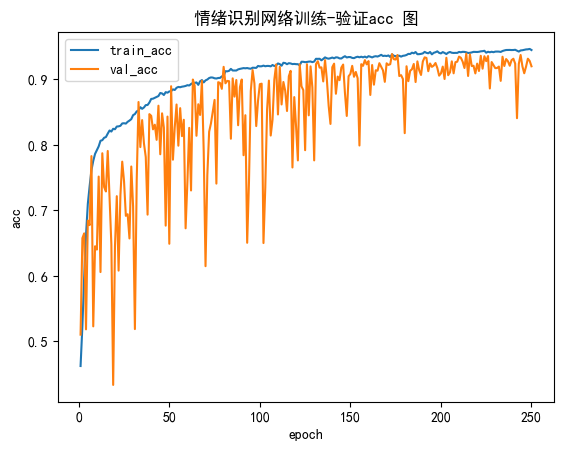

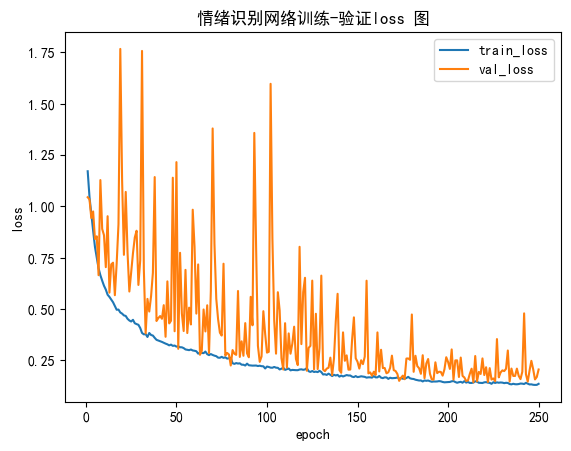

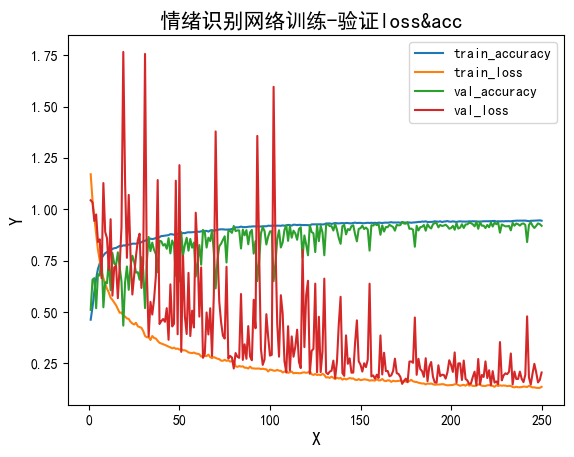

              precision    recall  f1-score   support

           0       0.66      0.87      0.75       223
           1       0.92      0.98      0.95       880
           2       0.88      0.08      0.14        90
           3       0.99      0.95      0.97      1229

    accuracy                           0.92      2422
   macro avg       0.86      0.72      0.70      2422
weighted avg       0.93      0.92      0.91      2422

[[ 195   24    1    3]
 [  18  862    0    0]
 [  69    0    7   14]
 [  14   51    0 1164]]


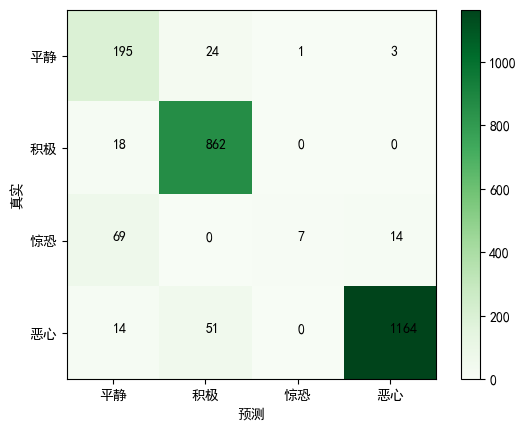

[情绪识别网络测试] accuracy:0.9199 precision:0.9199 recall:0.9199 f1:0.9199
=====FOLD_8=====


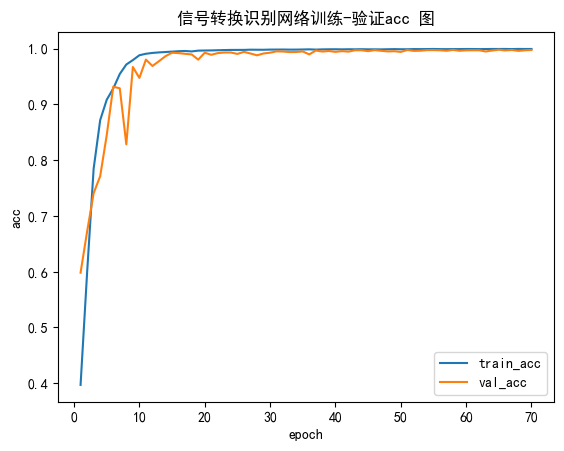

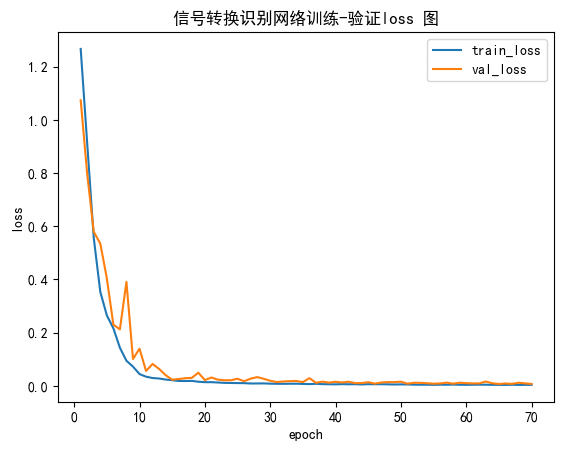

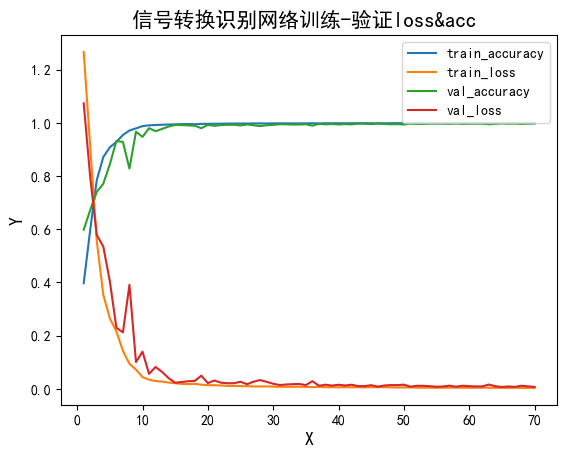

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       0.99      1.00      0.99      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2406    0    0    0   26]
 [   0 2432    0    0    0]
 [   0    0 2432    0    0]
 [   0    0    0 2432    0]
 [   3    0    0    0 2429]]


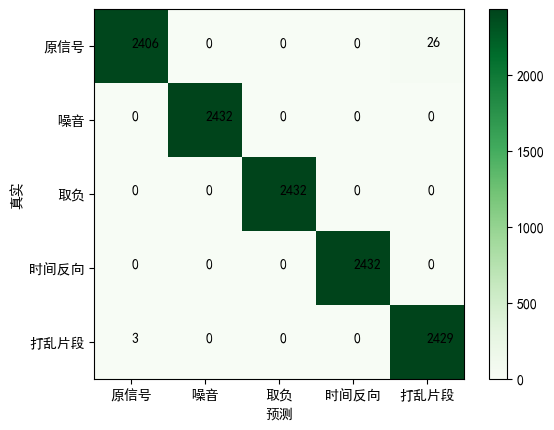

[信号转换识别网络测试] accuracy:0.9976 precision:0.9976 recall:0.9976 f1:0.9976


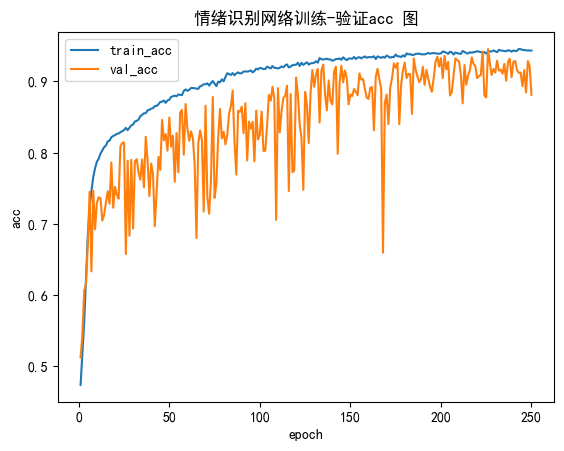

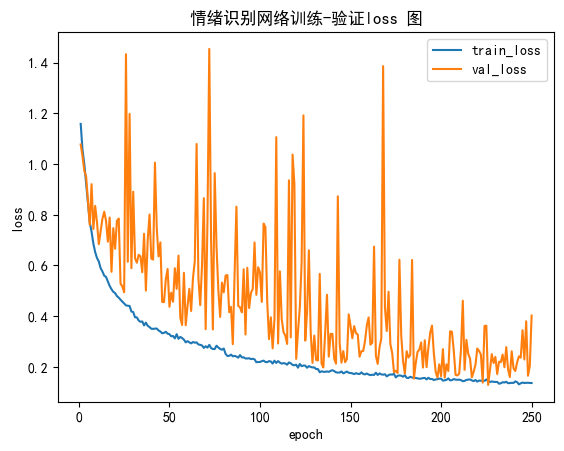

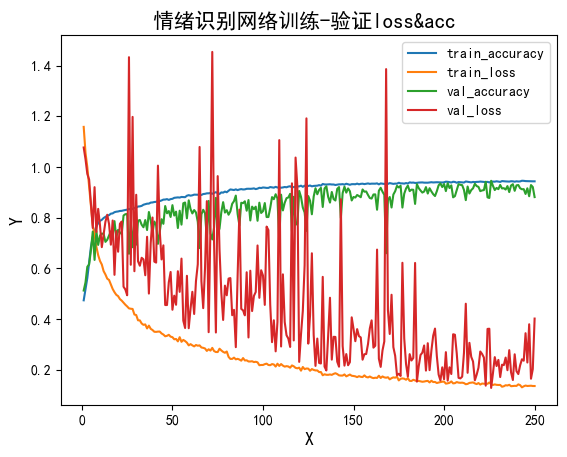

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.62      0.88      0.72       222
           1       0.85      0.97      0.91       880
           2       0.00      0.00      0.00        90
           3       0.99      0.88      0.93      1229

    accuracy                           0.88      2421
   macro avg       0.61      0.68      0.64      2421
weighted avg       0.87      0.88      0.87      2421

[[ 195   22    0    5]
 [  22  857    0    1]
 [  86    0    0    4]
 [  13  134    0 1082]]


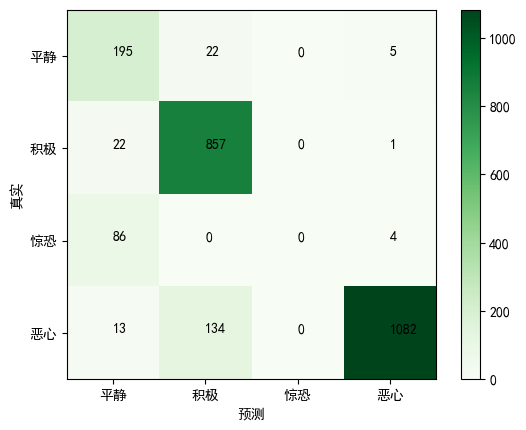

[情绪识别网络测试] accuracy:0.8815 precision:0.8815 recall:0.8815 f1:0.8815
=====FOLD_9=====


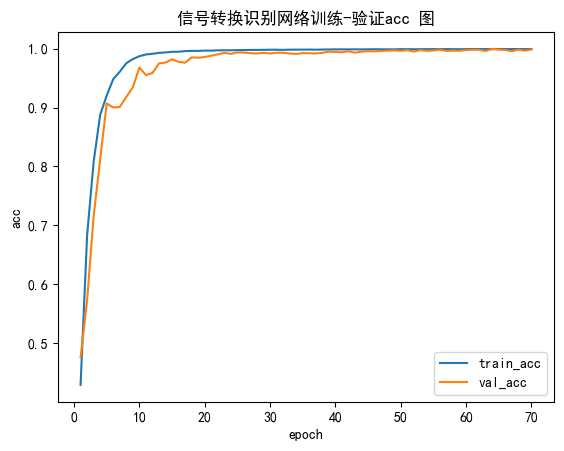

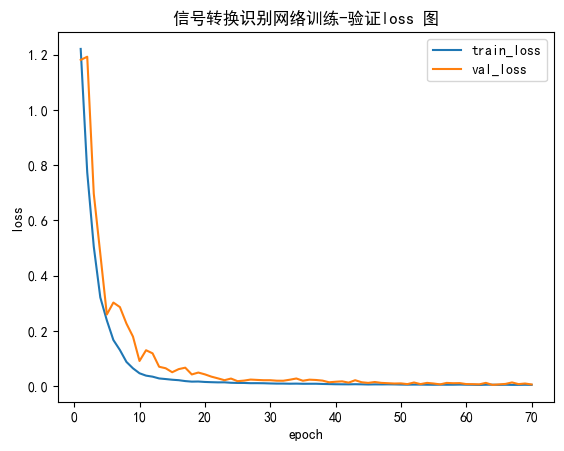

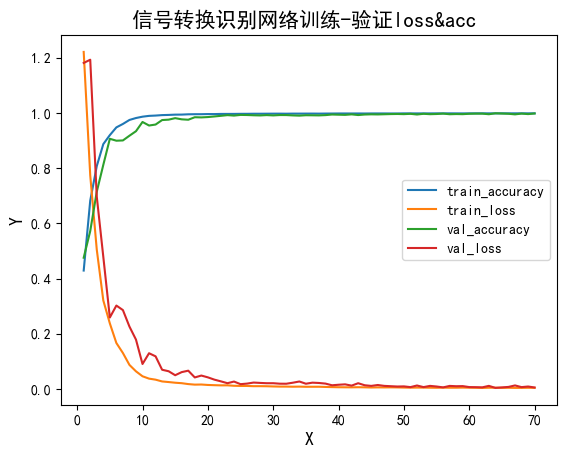

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2432
           1       1.00      1.00      1.00      2432
           2       1.00      1.00      1.00      2432
           3       1.00      1.00      1.00      2432
           4       1.00      1.00      1.00      2432

    accuracy                           1.00     12160
   macro avg       1.00      1.00      1.00     12160
weighted avg       1.00      1.00      1.00     12160

[[2422    0    0    0   10]
 [   0 2431    0    0    1]
 [   0    0 2432    0    0]
 [   0    0    0 2432    0]
 [   3    1    0    0 2428]]


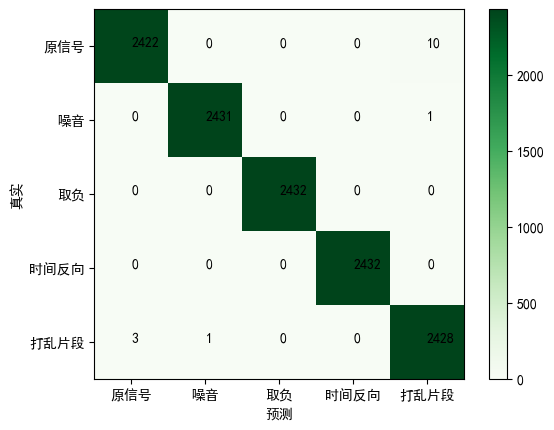

[信号转换识别网络测试] accuracy:0.9988 precision:0.9988 recall:0.9988 f1:0.9988


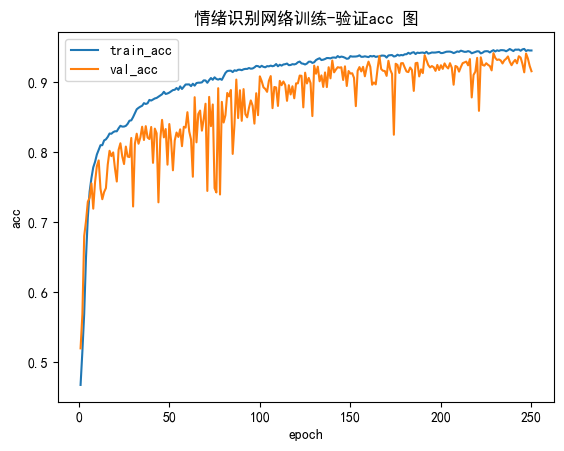

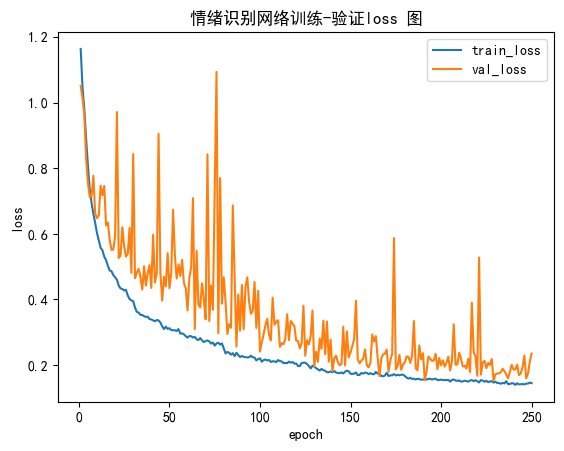

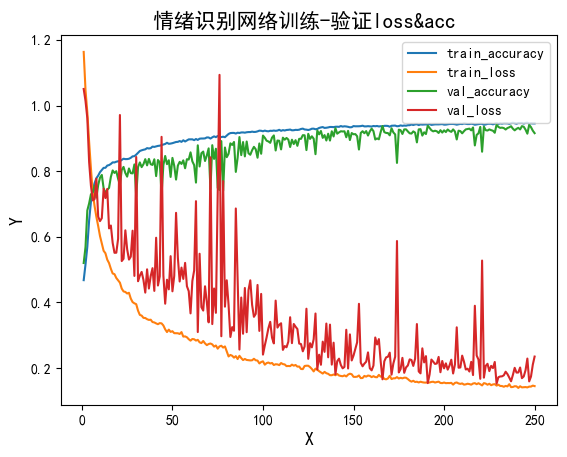

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.62      0.83      0.71       222
           1       1.00      0.91      0.95       880
           2       0.00      0.00      0.00        90
           3       0.93      1.00      0.96      1229

    accuracy                           0.92      2421
   macro avg       0.64      0.69      0.66      2421
weighted avg       0.89      0.92      0.90      2421

[[ 185    1    0   36]
 [  59  803    0   18]
 [  52    0    0   38]
 [   0    0    0 1229]]


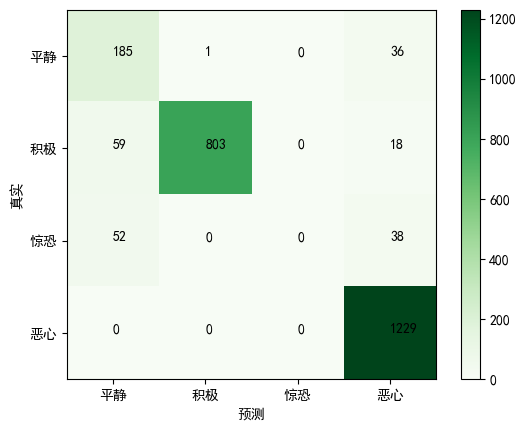

[情绪识别网络测试] accuracy:0.9157 precision:0.9157 recall:0.9157 f1:0.9157


In [14]:
# 训练
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1, 2, 3]

model1 = []
model2 = []
model3 = []
best_acc1,best_acc2 = 0.0,0.0


print("=====开始训练网络=====")

for k in range(total_fold):
    train_acc1,train_losses1,test_acc1,test_losses1,train_acc2,train_losses2,test_acc2,test_losses2 = [], [], [], [], [], [], [], []
    
    print("=====FOLD_{}=====".format(k))
    train_ECG = np.vstack((load_data[train_index_neutral[k],1:], load_data[train_index_positive[k],1:]))
    train_ECG = np.vstack((train_ECG, load_data[train_index_sick[k],1:]))
    train_ECG = np.vstack((train_ECG, load_data[train_index_fear[k],1:]))
    
    test_ECG = np.vstack((load_data[test_index_neutral[k],1:], load_data[test_index_positive[k],1:]))
    test_ECG = np.vstack((test_ECG, load_data[test_index_sick[k],1:]))
    test_ECG = np.vstack((test_ECG, load_data[test_index_fear[k],1:]))
    
    train_label = np.hstack((load_data[train_index_neutral[k],0], load_data[train_index_positive[k],0]))
    train_label = np.hstack((train_label, load_data[train_index_sick[k],0]))
    train_label = np.hstack((train_label, load_data[train_index_fear[k],0]))
    
    test_label = np.hstack((load_data[test_index_neutral[k],0], load_data[test_index_positive[k],0]))
    test_label = np.hstack((test_label, load_data[test_index_sick[k],0]))
    test_label = np.hstack((test_label, load_data[test_index_fear[k],0]))
    
#     train_ECG = np.vstack((neutral_data[train_index_neutral[k],1:], positive_data[train_index_positive[k],1:]))
#     train_ECG = np.vstack((train_ECG, sick_data[train_index_sick[k],1:]))
#     train_ECG = np.vstack((train_ECG, fear_data[train_index_fear[k],1:]))
    
#     test_ECG = np.vstack((neutral_data[test_index_neutral[k],1:], positive_data[test_index_positive[k],1:]))
#     test_ECG = np.vstack((test_ECG, sick_data[test_index_sick[k],1:]))
#     test_ECG = np.vstack((test_ECG, fear_data[test_index_fear[k],1:]))
    
#     train_label = np.vstack((neutral_data[train_index_neutral[k],0], positive_data[train_index_positive[k],0]))
#     train_label = np.vstack((train_label, sick_data[train_index_sick[k],0]))
#     train_label = np.vstack((train_label, fear_data[train_index_fear[k],0]))
#     test_label = np.vstack((neutral_data[test_index_neutral[k],0], positive_data[test_index_positive[k],0]))
#     test_label = np.vstack((test_label, sick_data[test_index_sick[k],0]))
#     test_label = np.vstack((test_label, fear_data[test_index_fear[k],0]))
    
#     train_ECG = load_data[train_index[k],1:]
#     test_ECG = load_data[test_index[k],1:]
    
#     train_label = load_data[train_index[k],0]
#     test_label = load_data[test_index[k],0]
    
#     #to one hot
#     data_tensor = torch.LongTensor(train_label)           
#     train_label = F.one_hot(data_tensor,len(transform_task))
#     data_tensor = torch.LongTensor(test_label)           
#     test_label = F.one_hot(data_tensor,len(transform_task))
    
    #net init
    model = model_CNN().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)#init weight
    model1.append(model)
    
    model= model_Task().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)
    model2.append(model)
    
    model= model_Final().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #model.apply(weigth_init)
    model3.append(model)
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(),lr=0.0001)#learning rate too large?
    #optimizer = optim.Adam(model1[k].parameters(),lr=initial_learning_rate)
    optimizer = torch.optim.SGD(model1[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_rate)
    
    #optimizer2 = optim.Adam(model2[k].parameters(),lr=initial_learning_rate)
    optimizer2 = torch.optim.SGD(model2[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=lr_decay_step, gamma=lr_decay_rate)
    
    #optimizer3 = optim.Adam(model3[k].parameters(),lr=initial_learning_rate)
    optimizer3 = torch.optim.SGD(model3[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=50, gamma=0.6)
    
    training_length = len(train_ECG)
    testing_length = len(test_ECG)
    
    
    
    #print("=====辅助任务训练开始=====")
    # epoch loop
    for epoch_counter in range(t_epoch):#only 100 times
        start = time.time()

#         tr_loss_task = np.zeros((len(transform_task), 1), dtype  = np.float32)
#         train_pred_task = np.zeros((len(transform_task), actual_batch_size), dtype  = np.float32) -1
#         train_true_task = np.zeros((len(transform_task), actual_batch_size), dtype  = np.float32) -1
#         tr_output_loss = 0
        
        model1[k].train()
        model2[k].train()

        running_loss = 0.0
        train_a = 0.0
        train_preds = []
        train_trues = []

        tr_total_gen_op = make_total_batch(data = train_ECG, length = training_length, batchsize = batchsize, 
                                                   noise_amount=noise_param, 
                                                   scaling_factor=scale_param, 
                                                   permutation_pieces=permu_param)
        
        for training_batch, training_labels, tr_counter, tr_steps in tr_total_gen_op:  
            ## run the model here

            inputs = np.asarray(training_batch)
            labels = np.asarray(training_labels)
            labels = labels.reshape(labels.shape[0])
            inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)
            predictions = model1[k](inputs)
            predictions = model2[k](predictions)
            
            loss = criterion(predictions,labels.long())
            optimizer.zero_grad()
            optimizer2.zero_grad()
            loss.backward()
            optimizer.step()
            optimizer2.step()


            running_loss += loss.data
            train_outputs = predictions.data.cpu().argmax(dim=1)
            acc = torch.sum(train_outputs.cpu() == labels.cpu()) / labels.shape[0]
            train_a += acc.item()

            train_preds.extend(train_outputs.detach().cpu().numpy())
            train_trues.extend(labels.detach().cpu().numpy())


        sklearn_accuracy = accuracy_score(train_trues, train_preds) 
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        
        train_loss = running_loss.cpu() / (tr_counter+1)
        train_a = train_a / (tr_counter+1)
        #print("[信号转换-训练集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter, train_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
        
        train_acc1.append(train_a)
        train_losses1.append(train_loss)

        scheduler.step()
        scheduler2.step()
        
        
        #val    
        model1[k].eval()
        model2[k].eval()
        
        running_loss = 0.0
        test_a = 0.0
        test_preds = []
        test_trues = []
        #print("=====开始测试辅助任务网络=====")
        te_total_gen_op = make_total_batch(data = test_ECG,length = testing_length, batchsize = batchsize, 
                                            noise_amount=noise_param, 
                                            scaling_factor=scale_param, 
                                            permutation_pieces=permu_param)

        with torch.no_grad():
            for testing_batch, testing_labels, te_counter, te_steps in te_total_gen_op:  
                ## run the model here

                inputs = np.asarray(testing_batch)
                labels = np.asarray(testing_labels)
                labels = labels.reshape(labels.shape[0])
                inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)
                predictions = model1[k](inputs)
                predictions = model2[k](predictions)
                
                loss = criterion(predictions,labels.long())
                
                running_loss += loss.data
                test_outputs = predictions.data.cpu().argmax(dim=1)
                acc = torch.sum(test_outputs.cpu() == labels.cpu()) / labels.shape[0]
                test_a += acc.item()

                test_preds.extend(test_outputs.detach().cpu().numpy())
                test_trues.extend(labels.detach().cpu().numpy())

            sklearn_accuracy = accuracy_score(test_trues, test_preds)
            sklearn_precision = precision_score(test_trues, test_preds, average='micro')
            sklearn_recall = recall_score(test_trues, test_preds, average='micro')
            sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
            
            test_loss = running_loss.cpu() / (te_counter+1)
            test_a = test_a / (te_counter+1)
            #print("[信号转换-验证集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,test_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
            test_acc1.append(test_a)
            test_losses1.append(test_loss)

        
        end = time.time()
        #print("=====epoch{} 耗时:{:.1f}秒=====".format(epoch_counter,end-start))
        
    #plot pic
    plot_all(t_epoch, train_acc1, train_losses1, test_acc1, test_losses1,"信号转换识别网络训练-验证")
    
    print(classification_report(test_trues, test_preds))
    conf_matrix = get_confusion_matrix(test_trues, test_preds)
    print(conf_matrix)
    plot_confusion_matrix(conf_matrix)
    print("[信号转换识别网络测试] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

    
    #print("=====辅助任务训练结束=====")
    
    # 保存模型?
    if sklearn_precision > best_acc1:
        print("保存最优信号转换模型model",k)
        torch.save(model1[k].state_dict(),"/home/whh/lt/models/pretask_best_model1")# 只保存模型参数
        torch.save(model2[k].state_dict(),"/home/whh/lt/models/pretask_best_model2")
        best_acc1 = sklearn_precision
    
    
    #print("=====情绪识别任务训练开始=====")
    for epoch_counter in range(epoch):
        start = time.time()
        
        
        #ssl down stream task
        #model1[k].eval()
        model1[k].train()
        model3[k].train()
        
        running_loss = 0.0
        train_a = 0.0
        train_preds = []
        train_trues = []
        
        train_data = MyData(train_ECG,train_label)
        train_loader = Data.DataLoader(dataset = train_data,batch_size=batchsize,shuffle=True, drop_last=False)
        
        for i,data in enumerate(train_loader):
            inputs,labels = data
            labels = labels.view(labels.shape[0])
            inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

            predictions = model1[k](inputs)
            predictions = model3[k](predictions)

            loss = criterion(predictions,labels.long())
            optimizer.zero_grad()
            optimizer3.zero_grad()
            loss.backward()
            optimizer.step()
            optimizer3.step()


            running_loss += loss.data
            train_outputs = predictions.data.cpu().argmax(dim=1)
            acc = torch.sum(train_outputs.cpu() == labels.cpu()) / labels.shape[0]
            train_a += acc.item()
            
            train_preds.extend(train_outputs.detach().cpu().numpy())
            train_trues.extend(labels.detach().cpu().numpy())
            
        sklearn_accuracy = accuracy_score(train_trues, train_preds) 
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        
        train_loss = running_loss.cpu() / (i+1)
        train_a = train_a / (i+1)
        #print("[情绪识别网络-训练集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,train_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
        
        train_acc2.append(train_a)
        train_losses2.append(train_loss)
            
        
        scheduler.step()
        scheduler3.step()
        
        #print("=====情绪识别训练结束=====")
        #down test
        model1[k].eval()
        model3[k].eval()

        running_loss = 0.0
        test_a = 0.0
        test_preds = []
        test_trues = []
        #print("=====开始测试情绪识别任务网络=====")
        test_data = MyData(test_ECG,test_label)
        test_loader = Data.DataLoader(dataset = test_data,batch_size=batchsize,shuffle=True, drop_last=False)

        with torch.no_grad():
            for i,data in enumerate(test_loader):
                inputs,labels = data
                labels = labels.view(labels.shape[0])
                inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

                predictions = model1[k](inputs)
                predictions = model3[k](predictions)
                test_outputs = predictions.data.cpu().argmax(dim=1)

                loss = criterion(predictions,labels.long())
                
                running_loss += loss.data
                test_outputs = predictions.data.cpu().argmax(dim=1)
                acc = torch.sum(test_outputs.cpu() == labels.cpu()) / labels.shape[0]
                test_a += acc.item()

                test_preds.extend(test_outputs.detach().cpu().numpy())
                test_trues.extend(labels.detach().cpu().numpy())

            sklearn_accuracy = accuracy_score(test_trues, test_preds)
            sklearn_precision = precision_score(test_trues, test_preds, average='micro')
            sklearn_recall = recall_score(test_trues, test_preds, average='micro')
            sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
            
            test_loss = running_loss.cpu() / (i+1)
            test_a = test_a / (i+1)
            #print("[情绪识别网络-验证集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,test_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
            test_acc2.append(test_a)
            test_losses2.append(test_loss)
            
        end = time.time()
        #print("=====epoch{} 耗时:{:.1f}秒=====".format(epoch_counter,end-start))
        
    #plot pic
    plot_all(epoch, train_acc2, train_losses2, test_acc2, test_losses2,"情绪识别网络训练-验证")
    
    #最后一次
    print(classification_report(test_trues, test_preds))
    conf_matrix = get_confusion_matrix2(test_trues, test_preds, no_of_emo)
    print(conf_matrix)
    plot_confusion_matrix2(conf_matrix, no_of_emo)
    print("[情绪识别网络测试] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
    
    
    # 保存模型
    if sklearn_precision > best_acc2:
        print("保存最优情绪识别模型model",k)
        torch.save(model1[k].state_dict(),"/home/whh/lt/models/final_best_model1")# 只保存模型参数
        torch.save(model3[k].state_dict(),"/home/whh/lt/models/final_best_model3")
        best_acc2 = sklearn_precision
    
            

=====开始训练网络=====
=====FOLD_0=====


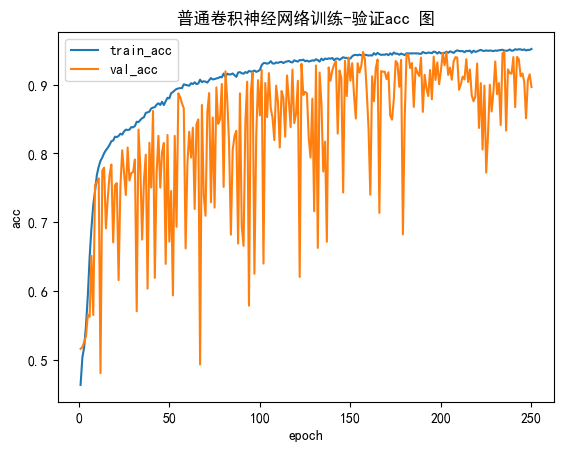

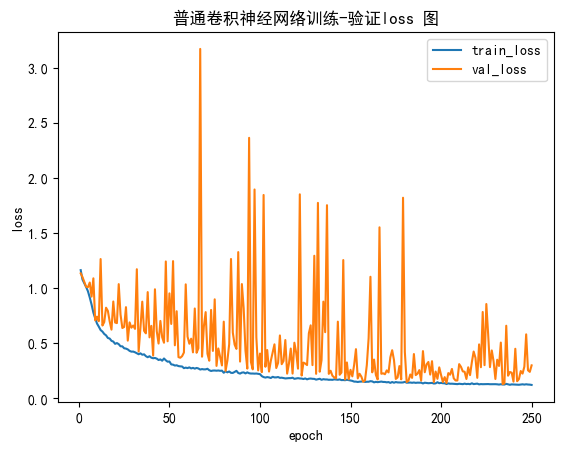

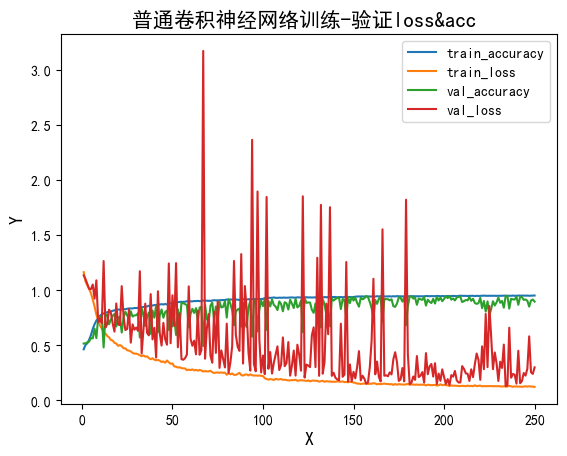

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.59      0.86      0.70       223
           1       0.90      0.98      0.94       881
           2       0.00      0.00      0.00        91
           3       0.98      0.91      0.94      1230

    accuracy                           0.90      2425
   macro avg       0.62      0.69      0.65      2425
weighted avg       0.88      0.90      0.88      2425

[[ 192   25    0    6]
 [   6  866    0    9]
 [  82    0    0    9]
 [  45   69    0 1116]]


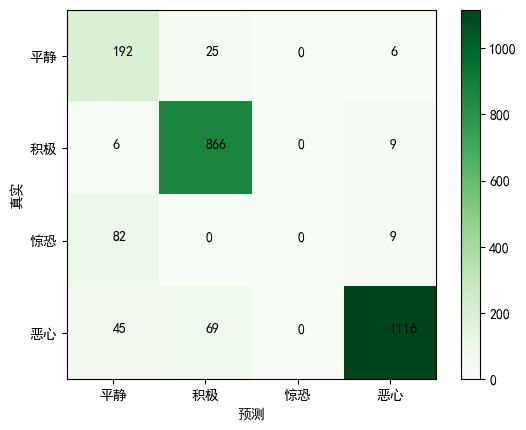

[最终测试] accuracy:0.8965 precision:0.8965 recall:0.8965 f1:0.8965
保存最优模型model 0
=====FOLD_1=====


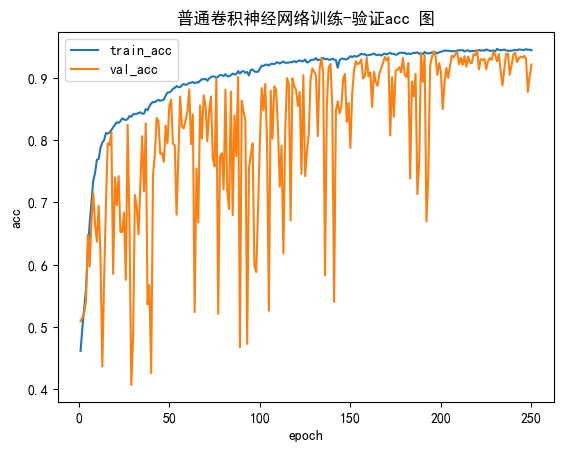

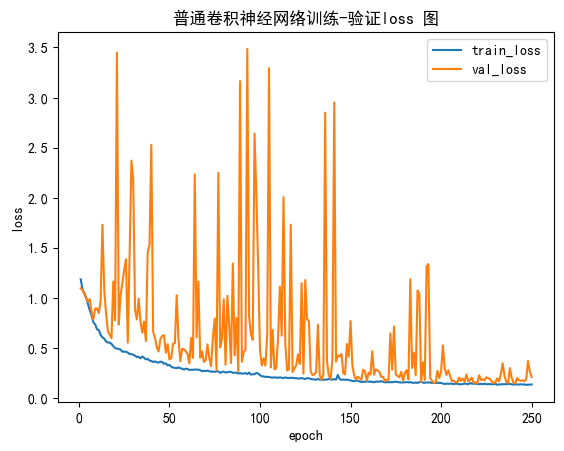

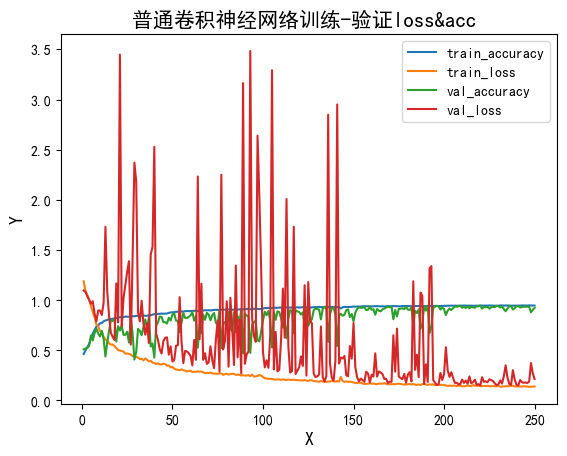

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.57      0.91      0.70       223
           1       0.96      0.97      0.96       881
           2       0.00      0.00      0.00        91
           3       1.00      0.96      0.98      1230

    accuracy                           0.92      2425
   macro avg       0.63      0.71      0.66      2425
weighted avg       0.91      0.92      0.91      2425

[[ 204   19    0    0]
 [  27  854    0    0]
 [  91    0    0    0]
 [  34   19    0 1177]]


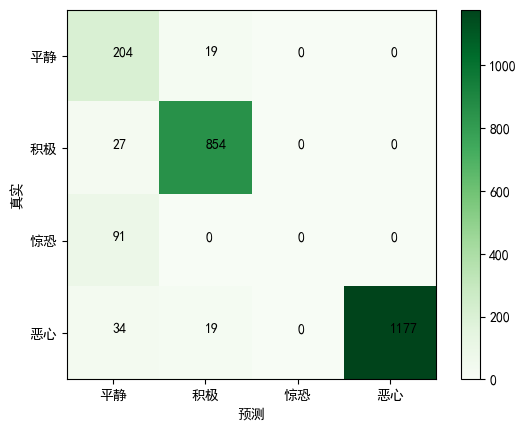

[最终测试] accuracy:0.9216 precision:0.9216 recall:0.9216 f1:0.9216
保存最优模型model 1
=====FOLD_2=====


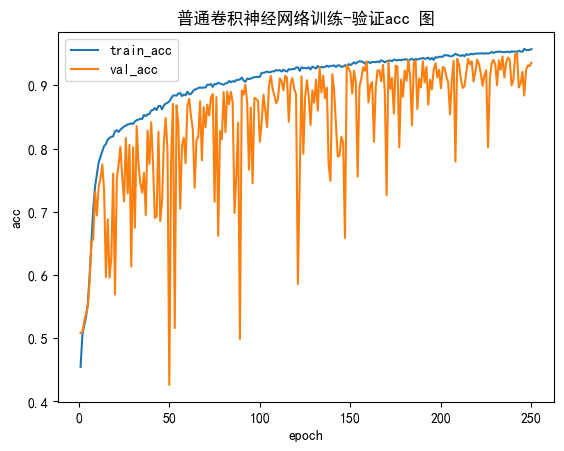

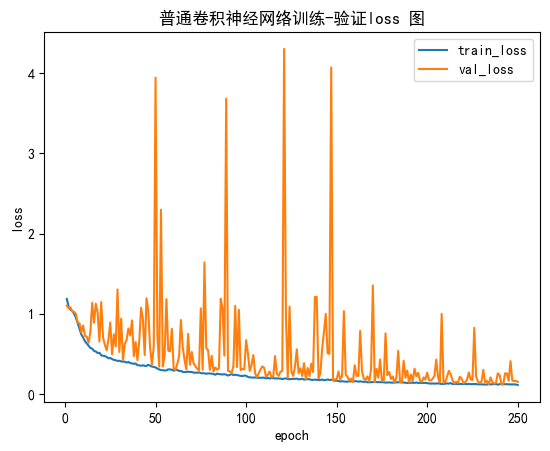

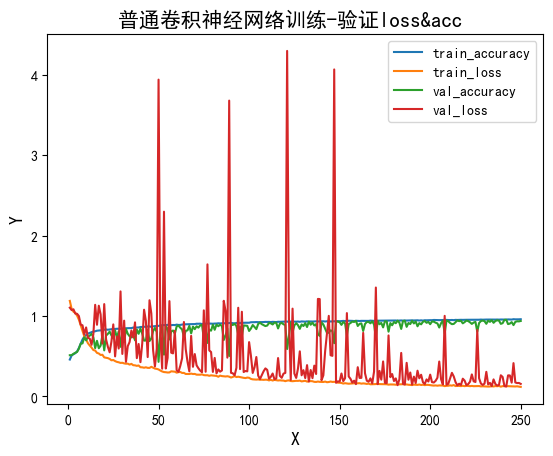

              precision    recall  f1-score   support

           0       0.67      0.94      0.78       223
           1       0.98      0.98      0.98       881
           2       0.37      0.20      0.26        91
           3       0.99      0.96      0.98      1230

    accuracy                           0.94      2425
   macro avg       0.75      0.77      0.75      2425
weighted avg       0.94      0.94      0.93      2425

[[ 209    8    2    4]
 [  16  863    0    2]
 [  73    0   18    0]
 [  16    6   29 1179]]


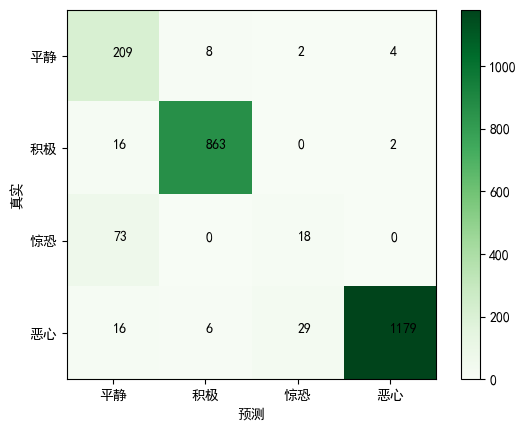

[最终测试] accuracy:0.9357 precision:0.9357 recall:0.9357 f1:0.9357
保存最优模型model 2
=====FOLD_3=====


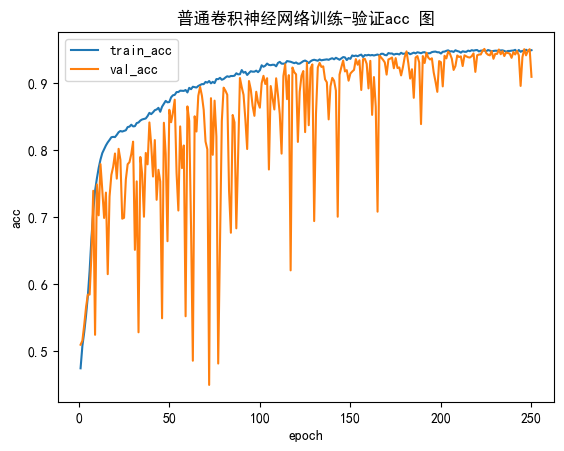

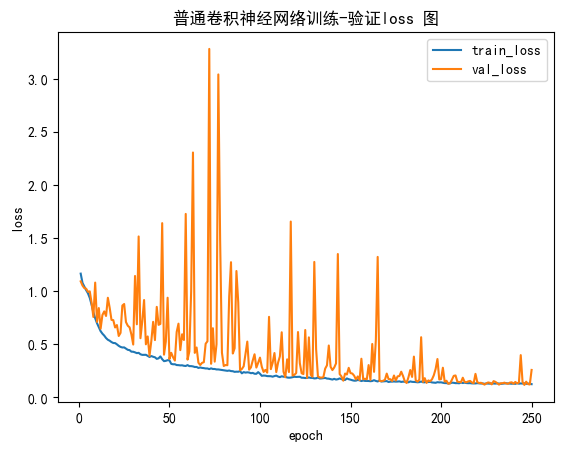

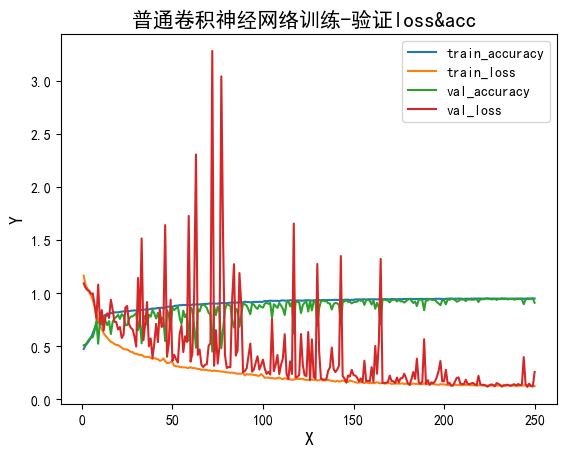

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.59      0.80      0.68       223
           1       0.93      0.97      0.95       881
           2       0.00      0.00      0.00        91
           3       0.97      0.95      0.96      1229

    accuracy                           0.91      2424
   macro avg       0.62      0.68      0.65      2424
weighted avg       0.89      0.91      0.90      2424

[[ 178   32    0   13]
 [  12  857    0   12]
 [  82    2    0    7]
 [  30   30    0 1169]]


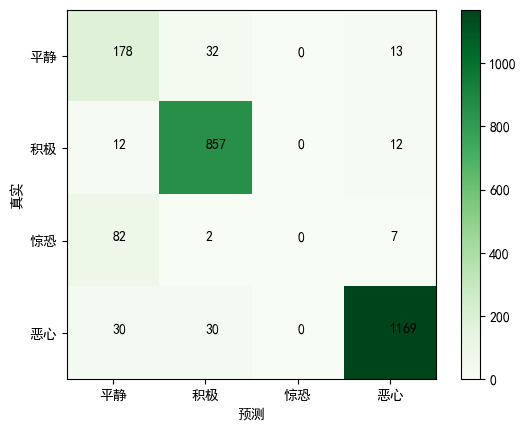

[最终测试] accuracy:0.9092 precision:0.9092 recall:0.9092 f1:0.9092
=====FOLD_4=====


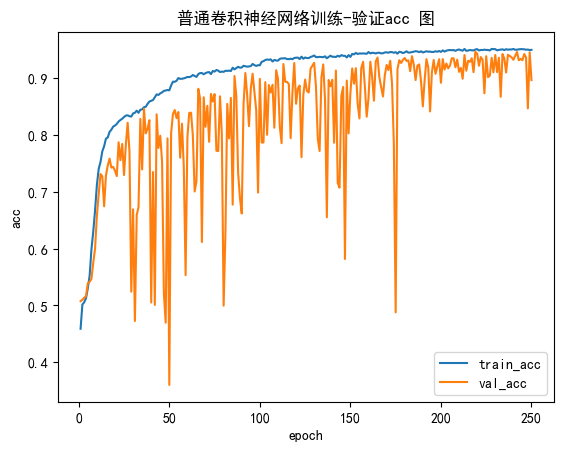

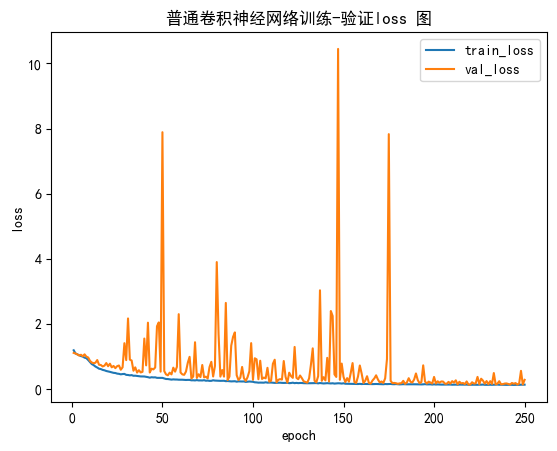

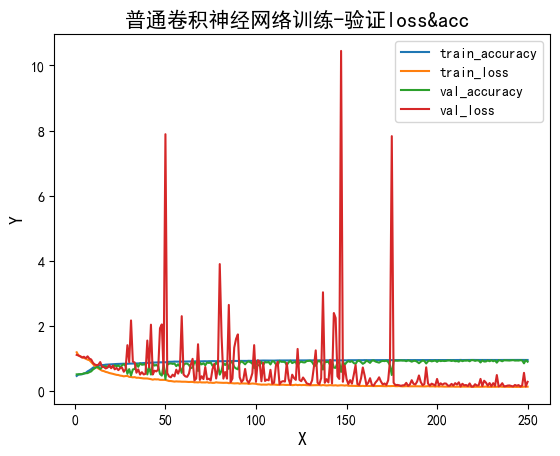

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.53      0.93      0.67       223
           1       1.00      0.83      0.91       881
           2       0.00      0.00      0.00        90
           3       0.95      1.00      0.97      1229

    accuracy                           0.90      2423
   macro avg       0.62      0.69      0.64      2423
weighted avg       0.89      0.90      0.89      2423

[[ 208    0    0   15]
 [ 122  735    0   24]
 [  64    0    0   26]
 [   0    0    0 1229]]


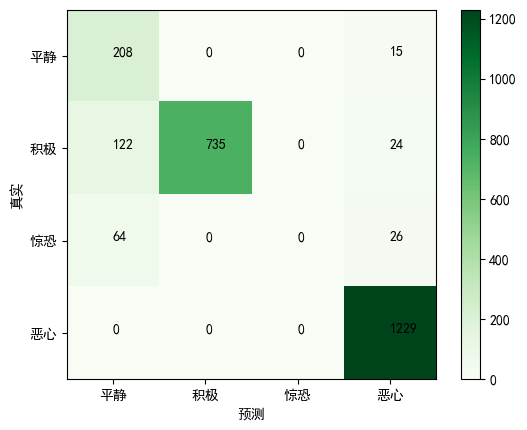

[最终测试] accuracy:0.8964 precision:0.8964 recall:0.8964 f1:0.8964
=====FOLD_5=====


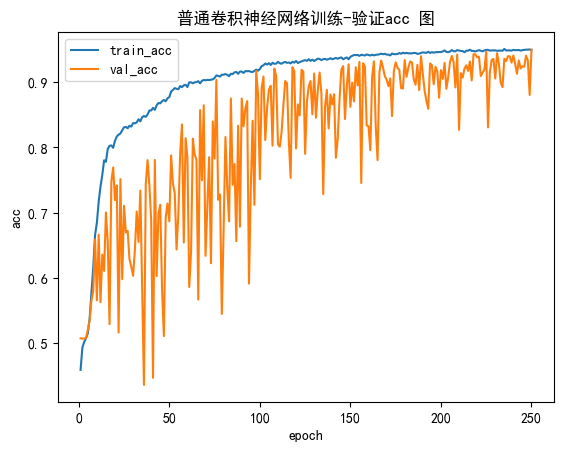

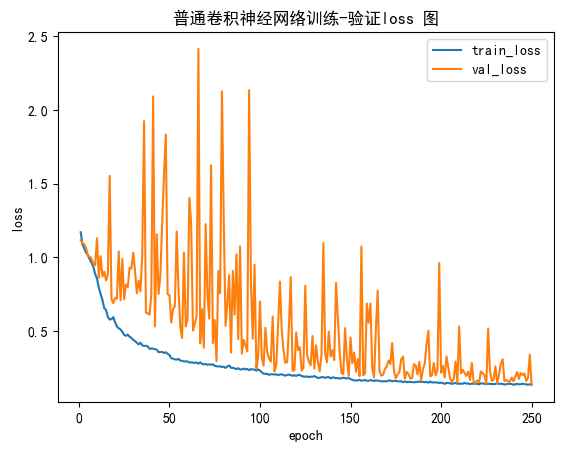

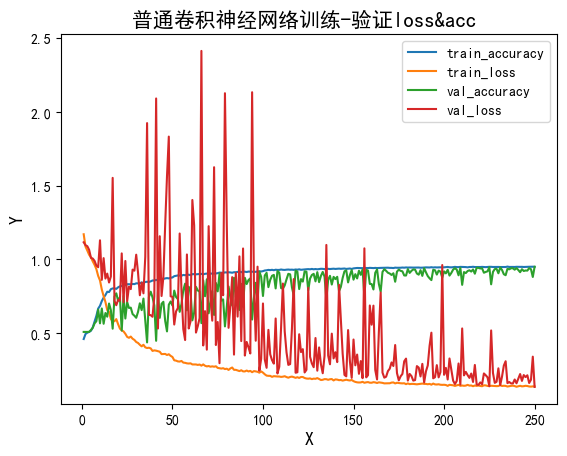

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      0.99      0.79       223
           1       1.00      0.97      0.99       880
           2       0.00      0.00      0.00        90
           3       1.00      0.99      1.00      1229

    accuracy                           0.95      2422
   macro avg       0.66      0.74      0.69      2422
weighted avg       0.93      0.95      0.94      2422

[[ 221    2    0    0]
 [  21  858    0    1]
 [  90    0    0    0]
 [   7    0    0 1222]]


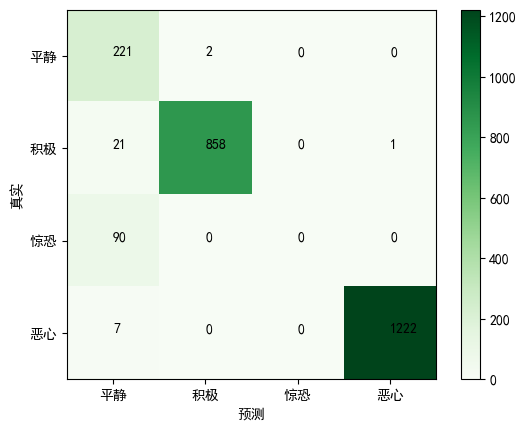

[最终测试] accuracy:0.9500 precision:0.9500 recall:0.9500 f1:0.9500
保存最优模型model 5
=====FOLD_6=====


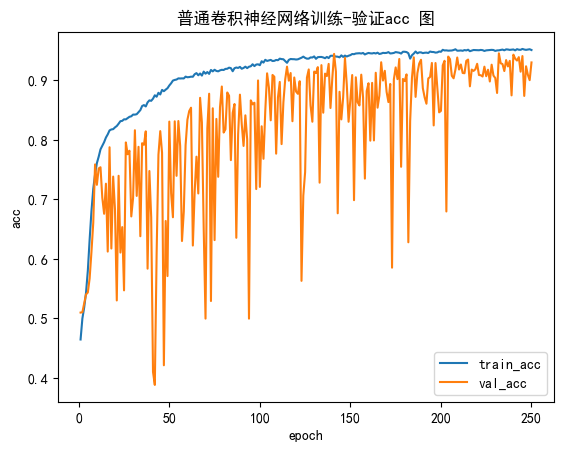

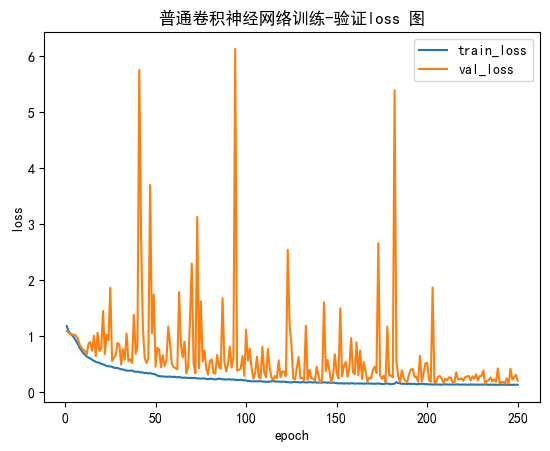

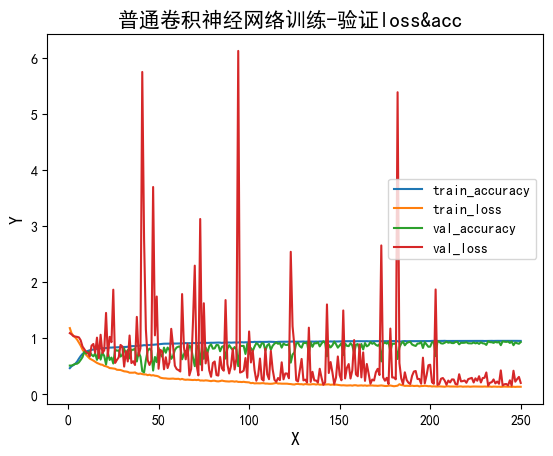

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.61      0.97      0.75       223
           1       0.97      0.99      0.98       880
           2       0.00      0.00      0.00        90
           3       0.99      0.95      0.97      1229

    accuracy                           0.93      2422
   macro avg       0.64      0.73      0.67      2422
weighted avg       0.91      0.93      0.92      2422

[[ 216    5    0    2]
 [   9  870    0    1]
 [  85    0    0    5]
 [  44   20    0 1165]]


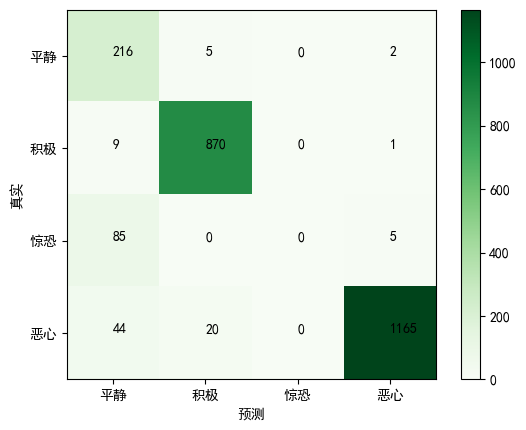

[最终测试] accuracy:0.9294 precision:0.9294 recall:0.9294 f1:0.9294
=====FOLD_7=====


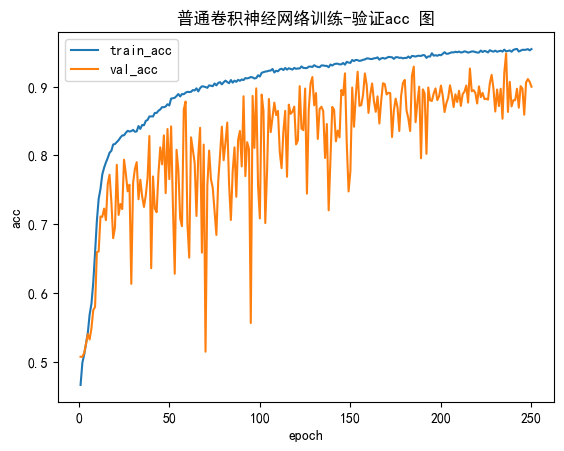

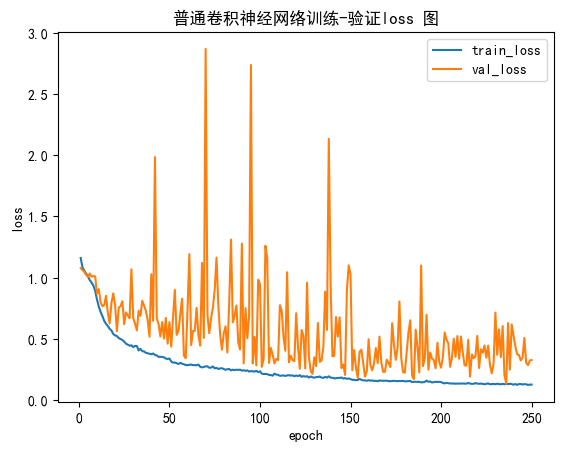

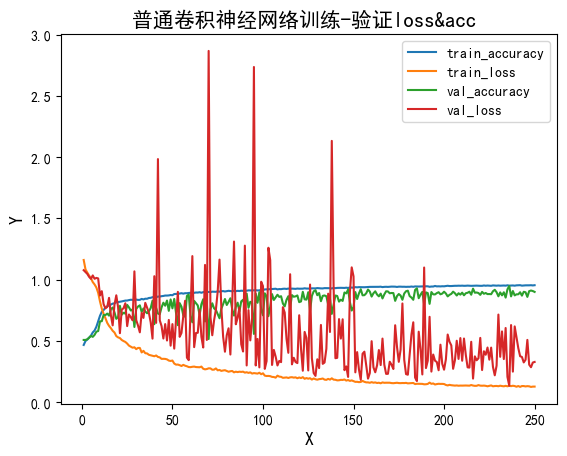

              precision    recall  f1-score   support

           0       0.61      0.80      0.69       223
           1       0.88      0.95      0.91       880
           2       0.90      0.30      0.45        90
           3       0.99      0.92      0.96      1229

    accuracy                           0.90      2422
   macro avg       0.84      0.74      0.75      2422
weighted avg       0.91      0.90      0.90      2422

[[ 179   42    1    1]
 [  38  838    0    4]
 [  58    0   27    5]
 [  20   72    2 1135]]


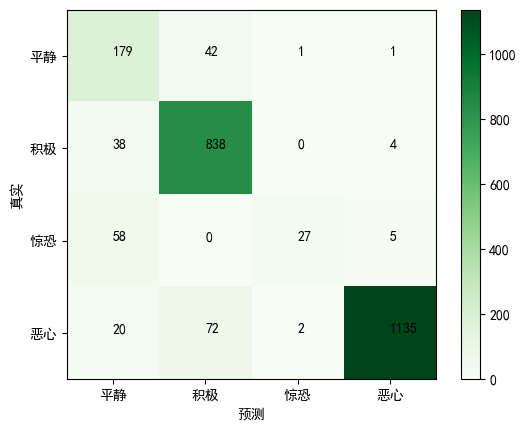

[最终测试] accuracy:0.8997 precision:0.8997 recall:0.8997 f1:0.8997
=====FOLD_8=====


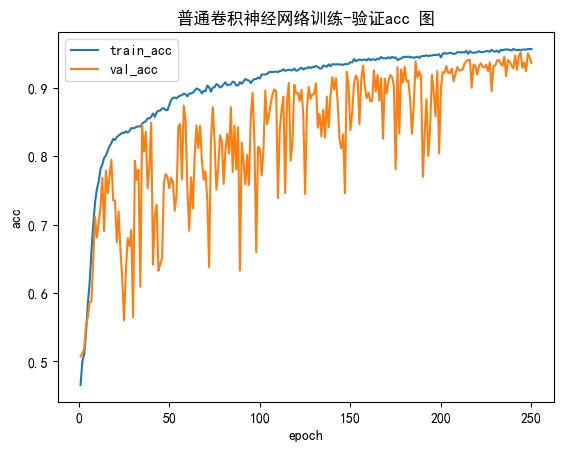

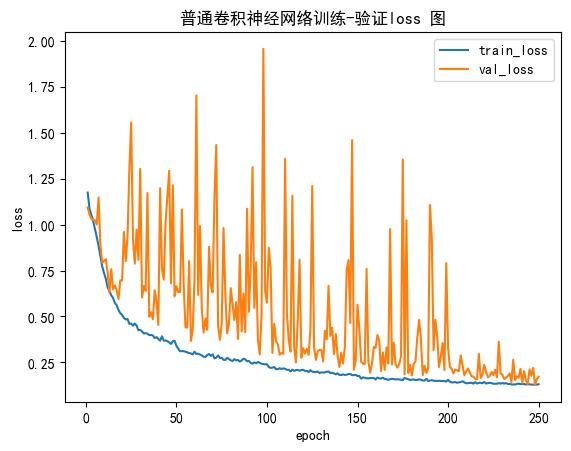

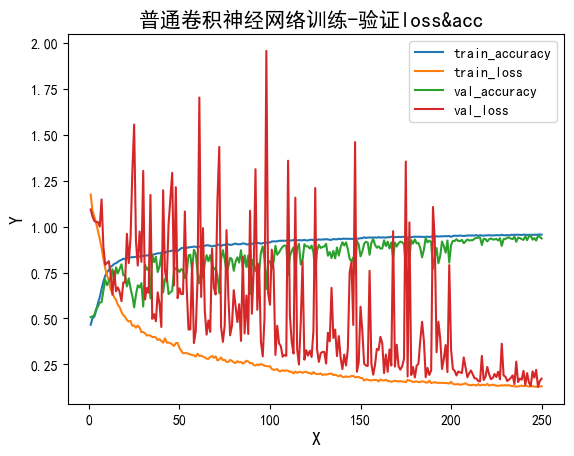

              precision    recall  f1-score   support

           0       0.65      0.92      0.76       222
           1       0.95      0.98      0.97       880
           2       0.88      0.08      0.14        90
           3       1.00      0.97      0.98      1229

    accuracy                           0.94      2421
   macro avg       0.87      0.74      0.71      2421
weighted avg       0.94      0.94      0.93      2421

[[ 204   16    0    2]
 [  17  862    0    1]
 [  81    0    7    2]
 [  11   25    1 1192]]


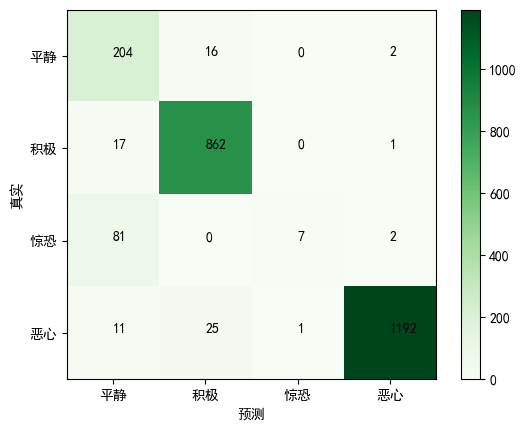

[最终测试] accuracy:0.9356 precision:0.9356 recall:0.9356 f1:0.9356
=====FOLD_9=====


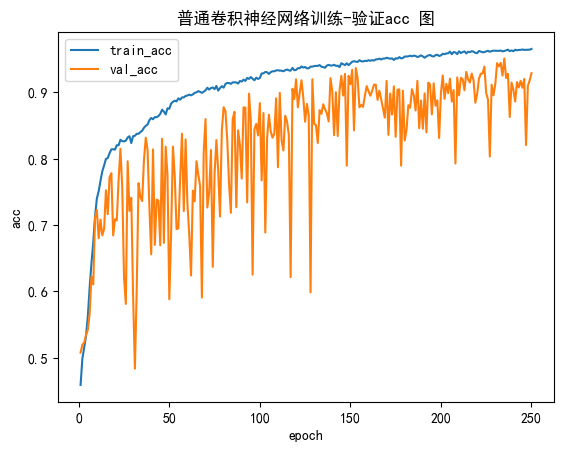

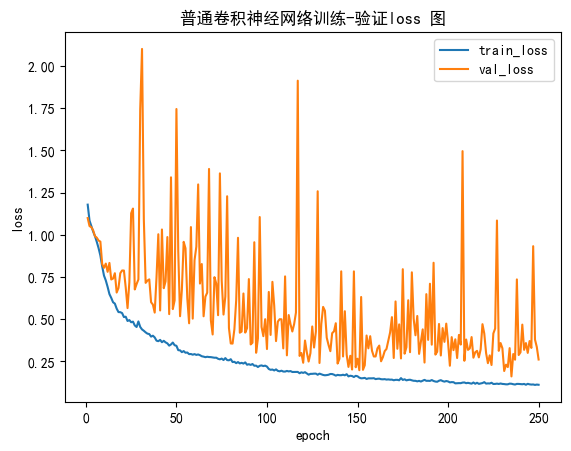

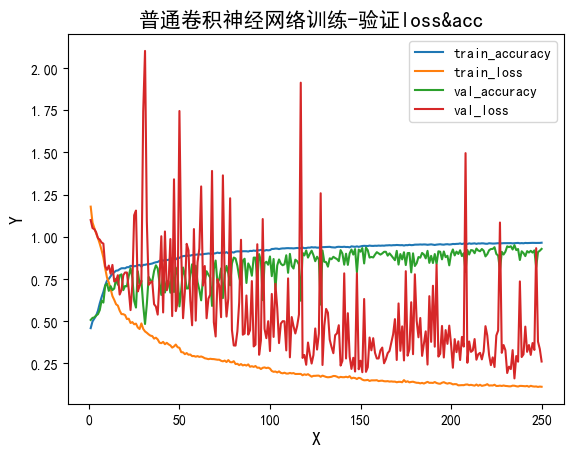

              precision    recall  f1-score   support

           0       0.63      0.97      0.77       222
           1       0.96      0.97      0.96       880
           2       0.85      0.52      0.65        90
           3       1.00      0.92      0.96      1229

    accuracy                           0.93      2421
   macro avg       0.86      0.85      0.83      2421
weighted avg       0.94      0.93      0.93      2421

[[ 216    6    0    0]
 [  25  855    0    0]
 [  43    0   47    0]
 [  57   34    8 1130]]


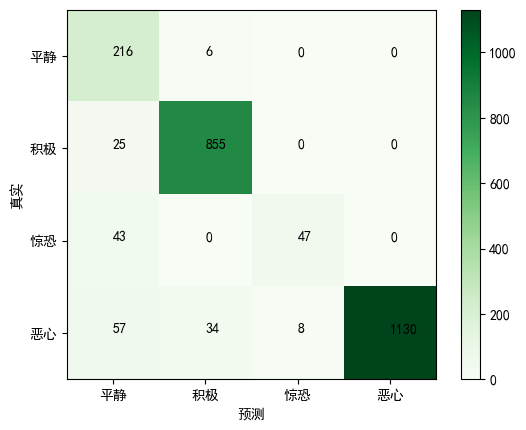

[最终测试] accuracy:0.9285 precision:0.9285 recall:0.9285 f1:0.9285


In [15]:

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1, 2, 3]

#训练

model1 = []
model2 = []
model3 = []
best_acc1,best_acc2 = 0.0,0.0


print("=====开始训练网络=====")

for k in range(total_fold):
    train_acc1,train_losses1,train_acc2,train_losses2,test_acc2,test_losses2 = [], [], [], [], [], []
    
    print("=====FOLD_{}=====".format(k))
    train_ECG = np.vstack((load_data[train_index_neutral[k],1:], load_data[train_index_positive[k],1:]))
    train_ECG = np.vstack((train_ECG, load_data[train_index_sick[k],1:]))
    train_ECG = np.vstack((train_ECG, load_data[train_index_fear[k],1:]))
    
    test_ECG = np.vstack((load_data[test_index_neutral[k],1:], load_data[test_index_positive[k],1:]))
    test_ECG = np.vstack((test_ECG, load_data[test_index_sick[k],1:]))
    test_ECG = np.vstack((test_ECG, load_data[test_index_fear[k],1:]))
    
    train_label = np.hstack((load_data[train_index_neutral[k],0], load_data[train_index_positive[k],0]))
    train_label = np.hstack((train_label, load_data[train_index_sick[k],0]))
    train_label = np.hstack((train_label, load_data[train_index_fear[k],0]))
    
    test_label = np.hstack((load_data[test_index_neutral[k],0], load_data[test_index_positive[k],0]))
    test_label = np.hstack((test_label, load_data[test_index_sick[k],0]))
    test_label = np.hstack((test_label, load_data[test_index_fear[k],0]))
    
    #net init
    modela = model_CNN().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #modela.apply(weigth_init)#init weight
    model1.append(modela)
    
    modelc= model_Final().to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    #modelc.apply(weigth_init)
    model3.append(modelc)
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(),lr=0.0001)#learning rate too large?
    #optimizer1 = optim.Adam(model1[k].parameters(),lr=initial_learning_rate)
    optimizer1 = torch.optim.SGD(model1[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=lr_decay_step, gamma=lr_decay_rate)
    #optimizer3 = optim.Adam(model3[k].parameters(),lr=initial_learning_rate)
    optimizer3 = torch.optim.SGD(model3[k].parameters(),lr=0.01,weight_decay=0.001)
    scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=lr_decay_step, gamma=lr_decay_rate)
    
    training_length = len(train_ECG)
    testing_length = len(test_ECG)
    
    
    # epoch loop
    for epoch_counter in range(epoch):
        start = time.time()
        
        #print("=====下游任务=====")
        #ssl down stream task
        model1[k].train()
        model3[k].train()
        
        running_loss = 0.0
        train_a = 0.0
        train_preds = []
        train_trues = []
        
        train_data = MyData(train_ECG,train_label)
        train_loader = Data.DataLoader(dataset = train_data,batch_size=batchsize,shuffle=True, drop_last=False)
        
        for i,data in enumerate(train_loader):
            inputs,labels = data
            labels = labels.view(labels.shape[0])
            inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

            predictions = model1[k](inputs)
            predictions = model3[k](predictions)

            loss = criterion(predictions,labels.long())
            optimizer1.zero_grad()
            optimizer3.zero_grad()
            loss.backward()
            optimizer1.step()
            optimizer3.step()


            running_loss += loss.data
            train_outputs = predictions.data.cpu().argmax(dim=1)
            acc = torch.sum(train_outputs.cpu() == labels.cpu()) / labels.shape[0]
            train_a += acc.item()
            
            train_preds.extend(train_outputs.detach().cpu().numpy())
            train_trues.extend(labels.detach().cpu().numpy())
            
        sklearn_accuracy = accuracy_score(train_trues, train_preds) 
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        
        train_loss = running_loss.cpu() / (i+1)
        train_a = train_a / (i+1)
        #print("[训练集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,train_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
        train_acc2.append(train_a)
        train_losses2.append(train_loss)
            
        scheduler1.step()
        scheduler3.step()
        
        
        
        #down test
        model1[k].eval()
        model3[k].eval()

        running_loss = 0.0
        test_a = 0.0
        test_preds = []
        test_trues = []
        #print("=====开始测试网络=====")
        test_data = MyData(test_ECG,test_label)
        test_loader = Data.DataLoader(dataset = test_data,batch_size=batchsize,shuffle=True, drop_last=False)

        with torch.no_grad():
            for i,data in enumerate(test_loader):
                inputs,labels = data
                labels = labels.view(labels.shape[0])
                inputs,labels = torch.as_tensor(inputs, dtype=torch.float32).to(device),torch.as_tensor(labels, dtype=torch.long).to(device)

                predictions = model1[k](inputs)
                predictions = model3[k](predictions)
                
                loss = criterion(predictions,labels.long())
                
                running_loss += loss.data
                test_outputs = predictions.data.cpu().argmax(dim=1)
                acc = torch.sum(test_outputs.cpu() == labels.cpu()) / labels.shape[0]
                test_a += acc.item()

                test_preds.extend(test_outputs.detach().cpu().numpy())
                test_trues.extend(labels.detach().cpu().numpy())

            sklearn_accuracy = accuracy_score(test_trues, test_preds)
            sklearn_precision = precision_score(test_trues, test_preds, average='micro')
            sklearn_recall = recall_score(test_trues, test_preds, average='micro')
            sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
            
            test_loss = running_loss.cpu() / (i+1)
            test_a = test_a / (i+1)
            #print("[验证集] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch_counter,test_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
         
            test_acc2.append(test_a)
            test_losses2.append(test_loss)
        
        end = time.time()
        #print("=====epoch{} 耗时:{:.1f}秒=====".format(k,end-start))
        
    #plot pic
    
    plot_all(epoch, train_acc2, train_losses2, test_acc2, test_losses2,"普通卷积神经网络训练-验证")
    
    #最后一次
    print(classification_report(test_trues, test_preds))
    conf_matrix = get_confusion_matrix2(test_trues, test_preds, no_of_emo)
    print(conf_matrix)
    plot_confusion_matrix2(conf_matrix, no_of_emo)
    print("[最终测试] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
    
    
    # 保存模型
    if sklearn_precision > best_acc2:
        print("保存最优模型model",k)
        torch.save(model1[k].state_dict(),"/home/whh/lt/models/cnn_final_best_model1")# 只保存模型参数
        torch.save(model3[k].state_dict(),"/home/whh/lt/models/cnn_final_best_model3")
        best_acc2 = sklearn_precision
    
            

In [15]:
print(positive_data[0,1:])

[-1.06697281e+02  3.85189056e-02 -1.53245497e+01 ...  8.41896286e+01
  8.46101532e+01  6.46902618e+01]


In [20]:
model = model_CNN()

im = torch.as_tensor(positive_data[0,1:], dtype=torch.float32).view(1,1250)
im.shape
im2 = model(im)

/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [21]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile
print(torch.__version__)

model_pth = '/home/whh/lt/models/cnn_final_best_model1'  # 训练得到的模型参数文件的路径(only params)
mobile_ptl = '/home/whh/lt/models/mobile_model1.ptl'  # 模型保存为Android可以调用的文件的路径
#model = mobilenet_v3_large(num_classes=7)  # 实例化模型
model = model_CNN()

pre_weights = torch.load(model_pth, map_location='cpu')  # 读取参数\
model.load_state_dict(pre_weights, strict=True)  # 将参数载入到模型
device = torch.device('cpu')  # 将torch.Tensor分配到的设备的对象，有cpu和cuda两种
model.to(device)  # 将模型加载到指定设备上
model.eval()  # 将模型设为验证模式

example = im  # 输入样例的格式为一张224*224的3通道图像

# 上面是准备模型，下面就是转换了
#traced_script_module = torch.jit.trace(model, example)
traced_script_module = torch.jit.script(model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter(mobile_ptl)

model_pth = '/home/whh/lt/models/cnn_final_best_model3'  # 训练得到的模型参数文件的路径(only params)
mobile_ptl = '/home/whh/lt/models/mobile_model3.ptl'  # 模型保存为Android可以调用的文件的路径
#model = mobilenet_v3_large(num_classes=7)  # 实例化模型
model = model_Final()

pre_weights = torch.load(model_pth, map_location='cpu')  # 读取参数\
model.load_state_dict(pre_weights, strict=True)  # 将参数载入到模型
device = torch.device('cpu')  # 将torch.Tensor分配到的设备的对象，有cpu和cuda两种
model.to(device)  # 将模型加载到指定设备上
model.eval()  # 将模型设为验证模式

example = im2  # 输入样例的格式为一张224*224的3通道图像

# 上面是准备模型，下面就是转换了
#traced_script_module = torch.jit.trace(model, example)
traced_script_module = torch.jit.script(model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter(mobile_ptl)



1.9.0+cu111


/home/whh/yes/envs/lt_pyth/lib/python3.9/site-packages/torch/jit/_script.py:1084: UserWarning: `optimize` is deprecated and has no effect. Use `with torch.jit.optimized_execution() instead
  warnings.warn(


In [22]:
model(im2)

tensor([[ 0.4195,  0.7138, -7.1879,  5.0666]], grad_fn=<AddmmBackward>)

In [34]:
Original_ECG = positive_data[0,1:]

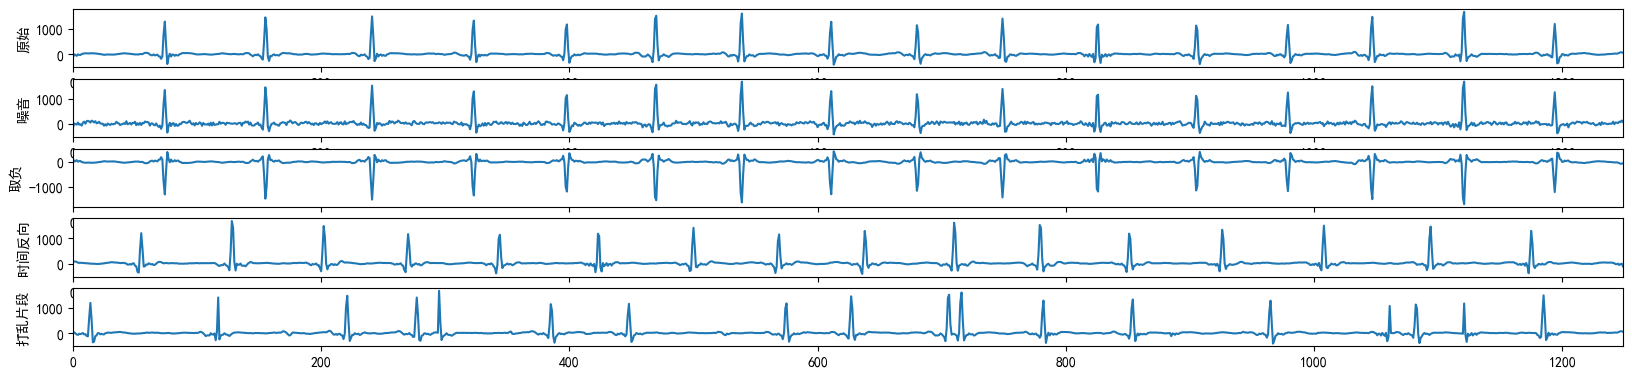

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt

#fliter = int(0.8*360)
# fliter = 16
# Give_up_size = int(fliter/2)
#record = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/100', sampfrom=0, sampto=25000, physical=True, channels=[0, ])
#Original_ECG = record.p_signal[0:2000].flatten()
#print(Original_ECG.shape)
#print(Original_ECG)
# ECG_baseline = medfilt(Original_ECG, fliter+1)
# Filtered_ECG = Original_ECG - ECG_baseline

plt.figure(figsize=(20, 8))
plt.subplot(9, 1, 1)
plt.ylabel("原始")
plt.plot(Original_ECG)#输出原图像
plt.margins(x=0)

ECG_baseline = add_noise_with_SNR(Original_ECG, noise_amount = 15)
Filtered_ECG = minus_ecg(Original_ECG)
plt.subplot(9, 1, 2)
plt.ylabel("噪音")
plt.plot(ECG_baseline)#输出基线轮廓
plt.margins(x=0)
plt.subplot(9, 1, 3)
plt.ylabel("取负")
plt.plot(Filtered_ECG)#基线滤波结果
plt.margins(x=0)

ECG_baseline = flip_ecg(Original_ECG)
Filtered_ECG =  shuffle_ecg(Original_ECG, pieces = 20) # 2-20
plt.subplot(9, 1, 4)
plt.ylabel("时间反向")
plt.plot(ECG_baseline)#输出基线轮廓
plt.margins(x=0)
plt.subplot(9, 1, 5)
plt.ylabel("打乱片段")
plt.plot(Filtered_ECG)#基线滤波结果
plt.margins(x=0)

# fliter = 128
# Give_up_size = int(fliter/2)
# #record = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/100', sampfrom=0, sampto=25000, physical=True, channels=[0, ])
# #Original_ECG = record.p_signal[0:2000].flatten()
# #print(Original_ECG.shape)
# #print(Original_ECG)
# ECG_baseline = medfilt(Original_ECG, fliter+1)
# Filtered_ECG = Original_ECG - ECG_baseline
# plt.subplot(9, 1, 8)
# plt.ylabel("baseline")
# plt.plot(ECG_baseline[Give_up_size:-Give_up_size])#输出基线轮廓
# plt.margins(x=0)
# plt.subplot(9, 1, 9)
# plt.ylabel("Filter 128")
# plt.plot(Filtered_ECG[Give_up_size:-Give_up_size]+np.sum(ECG_baseline[Give_up_size:-Give_up_size])/(len(Original_ECG)-fliter))#基线滤波结果
# plt.margins(x=0)

plt.show()

In [16]:
model = model_CNN()

im = torch.as_tensor(positive_data[0,1:], dtype=torch.float32).view(1,1250)
im.shape
im2 = model(im)